# Librerias y Preprocesamiento de datos espaciales.

In [ ]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import geopandas as gpd
import json
import os

#ee.Authenticate()

# Inicializar la API de Earth Engine
ee.Initialize(project='curso-colombia-467723')

# Crear un mapa interactivo
Map = geemap.Map()

# Montar Google Drive (para Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ruta a tu archivo GeoJSON en Google Drive
geojson_path = '/home/irm/proyectos/puntos_entrenamiento_combinados2.geojson'

# Leer el archivo GeoJSON usando geopandas
gdf = gpd.read_file(geojson_path)

# Imprimir información básica sobre los puntos de entrenamiento
print(f"Total de puntos de entrenamiento: {len(gdf)}")
print("Distribución de clases:")
print(gdf['clase'].value_counts())

# Definir el área de interés (ROI)
roi = ee.FeatureCollection('projects/curso-colombia-467723/assets/Nuble_comunas_')

# Centrar el mapa en el ROI
Map.centerObject(roi, 10)

Total de puntos de entrenamiento: 1750
Distribución de clases:
clase
urbano        250
vegetacion    250
cultivos      250
nieve         250
agua          250
suelo         250
suelo2        250
Name: count, dtype: int64


In [ ]:
# Definir años de interés para el periodo 1985-2012
años = list(range(1985, 2013))  # Genera lista desde 1985 hasta 2012

# Definir las clases para la clasificación (usando los valores del GeoJSON)
clases = {
    'urbano': {'color': '#ff0000', 'clase': 0},
    'vegetacion': {'color': '#00ff00', 'clase': 1},
    'cultivos': {'color': '#ffff00', 'clase': 2},
    'nieve': {'color': '#ffffff', 'clase': 3},
    'agua': {'color': '#0000ff', 'clase': 4},
    'suelo': {'color': '#ff9900', 'clase': 5},
    'suelo2': {'color': '#994c00', 'clase': 6}
}

In [ ]:
def geojson_to_ee(geojson_path, clases_dict):
    """
    Convierte un archivo GeoJSON en un FeatureCollection de Earth Engine
    y convierte los nombres de clase en valores numéricos.

    Args:
        geojson_path: Ruta al archivo GeoJSON
        clases_dict: Diccionario que mapea nombres de clase a valores numéricos

    Returns:
        ee.FeatureCollection con los puntos de entrenamiento
    """
    # Crear un mapeo inverso de nombres de clase a valores numéricos
    clase_a_numero = {k: v['clase'] for k, v in clases_dict.items()}

    # Leer el archivo GeoJSON
    with open(geojson_path, 'r') as f:
        geojson_data = json.load(f)

    # Convertir características a formato EE
    features = []
    for feature in geojson_data['features']:
        geometry = feature['geometry']
        properties = feature['properties'].copy()

        # Convertir el valor de clase de texto a número si es necesario
        if 'clase' in properties and isinstance(properties['clase'], str):
            clase_texto = properties['clase'].lower()  # Convertir a minúsculas para consistencia
            if clase_texto in clase_a_numero:
                properties['clase'] = clase_a_numero[clase_texto]
            else:
                print(f"ADVERTENCIA: Clase '{properties['clase']}' no reconocida.")

        # Crear feature de EE
        ee_feature = ee.Feature(
            ee.Geometry.Point(geometry['coordinates']),
            properties
        )
        features.append(ee_feature)

    # Crear FeatureCollection
    return ee.FeatureCollection(features)

# Convertir GeoJSON a FeatureCollection con conversión de clases
puntosTrain = geojson_to_ee(geojson_path, clases)

# Verificar número de puntos en el FeatureCollection
print(f"Número de puntos en Earth Engine: {puntosTrain.size().getInfo()}")

# Definir el área de interés (ROI) basado en el extent del GeoJSON
bbox = gdf.total_bounds  # [xmin, ymin, xmax, ymax]
roi = ee.Geometry.Rectangle([bbox[0], bbox[1], bbox[2], bbox[3]])

# Centrar el mapa en el ROI
Map.centerObject(roi, 10)
Map.addLayer(roi, {}, 'Área de interés')

Número de puntos en Earth Engine: 1750


# Validacion k-fold y evaluacion

In [ ]:
# Función para dividir FeatureCollection en k-folds
def kFoldSplit(features, k):
    """
    Divide una colección de características en k pliegues para validación cruzada.

    Args:
        features: ee.FeatureCollection con los puntos de entrenamiento
        k: Número de pliegues para la validación cruzada

    Returns:
        ee.FeatureCollection con los pliegues para entrenamiento y validación
    """
    step = ee.Number(1).divide(k)
    thresholds = ee.List.sequence(0, ee.Number(1).subtract(step), step)

    # Añadir columna aleatoria para la división
    features = features.randomColumn(seed=42)

    # Crear los pliegues
    def create_fold(threshold):
        threshold = ee.Number(threshold)

        # Filtrar para obtener conjunto de entrenamiento
        trainingSplit = features.filter(
            ee.Filter.Or(
                ee.Filter.lt('random', threshold),
                ee.Filter.gte('random', threshold.add(step))
            )
        )

        # Filtrar para obtener conjunto de validación
        validationSplit = features.filter(
            ee.Filter.And(
                ee.Filter.gte('random', threshold),
                ee.Filter.lt('random', threshold.add(step))
            )
        )

        return ee.Feature(None, {
            'training': trainingSplit,
            'validation': validationSplit
        })

    splits = thresholds.map(lambda t: create_fold(t))
    return ee.FeatureCollection(splits)

# Función para calcular y mostrar la importancia de variables (índice Gini)
def calcularImportanciaGini(classifier, bands):
    """
    Calcula y muestra la importancia de variables basada en el índice Gini.
    """
    importance = classifier.explain().get('importance')
    importance_dict = importance.getInfo()

    importance_df = pd.DataFrame({
        'Variable': list(importance_dict.keys()),
        'Importancia': list(importance_dict.values())
    })
    importance_df = importance_df.sort_values('Importancia', ascending=False)

    print('Importancia de variables (basada en reducción de impureza Gini):')
    display(importance_df)

    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Variable'], importance_df['Importancia'])
    plt.title('Importancia de variables basada en índice Gini')
    plt.xlabel('Variable')
    plt.ylabel('Importancia (reducción de impureza Gini)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return importance

# Función para visualizar detalladamente la matriz de confusión
def mostrarMatrizConfusion(matriz, nombreClases):
    """
    Visualiza detalladamente la matriz de confusión y métricas asociadas.
    """
    matrizArray = matriz.array().getInfo()
    precision = matriz.producersAccuracy().getInfo()
    recall = matriz.consumersAccuracy().getInfo()

    matriz_df = pd.DataFrame(matrizArray,
                            index=nombreClases,
                            columns=nombreClases)

    print('Matriz de Confusión:')
    display(matriz_df)

    # Preparar los datos según el formato devuelto
    if isinstance(precision, dict):
        precision_values = list(precision.values())
    else:
        precision_values = precision

    if isinstance(recall, dict):
        recall_values = list(recall.values())
    else:
        recall_values = recall

    # Asegurarnos de tener suficientes valores
    while len(precision_values) < len(nombreClases):
        precision_values.append(None)
    while len(recall_values) < len(nombreClases):
        recall_values.append(None)

    precision_df = pd.DataFrame({
        'Clase': nombreClases,
        'Precisión (Producer\'s Accuracy)': precision_values[:len(nombreClases)]
    })

    recall_df = pd.DataFrame({
        'Clase': nombreClases,
        'Exhaustividad (Consumer\'s Accuracy/Recall)': recall_values[:len(nombreClases)]
    })

    print('\nPrecisión por clase (Producer\'s Accuracy):')
    display(precision_df)

    print('\nExhaustividad por clase (Consumer\'s Accuracy/Recall):')
    display(recall_df)

    print(f"\nExactitud global (Overall Accuracy): {matriz.accuracy().getInfo():.4f}")
    print(f"Coeficiente Kappa: {matriz.kappa().getInfo():.4f}")

    return {
        'matriz': matriz,
        'precision': precision,
        'recall': recall
    }

# Función para realizar la validación cruzada
def realizarValidacionCruzada(imagen, puntosTrain, bands, numFolds, nombreClases):
    """
    Realiza validación cruzada para evaluar el rendimiento del clasificador.
    """
    folds = kFoldSplit(puntosTrain, numFolds)

    def procesarFold(fold):
        trainingPoints = ee.FeatureCollection(fold.get('training'))
        validationPoints = ee.FeatureCollection(fold.get('validation'))

        training = imagen.select(bands).sampleRegions(
            collection=trainingPoints,
            properties=['clase'],
            scale=30,
            tileScale=16
        )

        classifier = ee.Classifier.smileRandomForest(
            numberOfTrees=100,
            minLeafPopulation=10
        ).train(
            features=training,
            classProperty='clase',
            inputProperties=bands
        )

        validation = imagen.select(bands).sampleRegions(
            collection=validationPoints,
            properties=['clase'],
            scale=30,
            tileScale=16
        )

        confMatrix = validation.classify(classifier).errorMatrix('clase', 'classification')

        return ee.Feature(None, {
            'accuracy': confMatrix.accuracy(),
            'kappa': confMatrix.kappa(),
            'matrix': confMatrix
        })

    accuracies = ee.FeatureCollection(folds.map(procesarFold))

    accuracyValues = accuracies.aggregate_array('accuracy').getInfo()
    kappaValues = accuracies.aggregate_array('kappa').getInfo()

    meanAccuracy = accuracies.aggregate_mean('accuracy').getInfo()
    meanKappa = accuracies.aggregate_mean('kappa').getInfo()

    print('Resultados de la Validación Cruzada:')
    print(f'Accuracies por fold: {accuracyValues}')
    print(f'Kappas por fold: {kappaValues}')
    print(f'Accuracy promedio: {meanAccuracy:.4f}')
    print(f'Kappa promedio: {meanKappa:.4f}')

    return {
        'accuracies': accuracyValues,
        'kappas': kappaValues,
        'meanAccuracy': meanAccuracy,
        'meanKappa': meanKappa
    }

# Seleccion de coleccion landsat


In [ ]:
def seleccionarColeccionLandsat(año):
    """
    Selecciona la colección Landsat apropiada según el año con manejo mejorado
    para garantizar suficientes imágenes.

    Args:
        año: Año para el cual se seleccionará la colección

    Returns:
        Objeto con la colección y función para renombrar bandas
    """
    # Definir fechas para el año actual
    startDate = ee.Date.fromYMD(año, 1, 1)
    endDate = ee.Date.fromYMD(año, 12, 31)

    # Configurar umbral de nubes inicial
    cloud_threshold = 20

    # Seleccionar colección según el año
    if año < 1999:
        # Usar Landsat 5 TM para 1985-1998
        collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
            .filterBounds(roi) \
            .filterDate(startDate, endDate) \
            .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))

        # Si hay muy pocas imágenes, aumentar el umbral de nubes
        if collection.size().getInfo() < 3:
            cloud_threshold = 50
            print(f"Pocas imágenes disponibles para {año}. Aumentando umbral de nubes a {cloud_threshold}%")
            collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
                .filterBounds(roi) \
                .filterDate(startDate, endDate) \
                .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))

        # Función para renombrar bandas de Landsat 5
        def renameBands(image):
            return image.select(
                ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'],
                ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
            )

    elif año < 2003:
        # Usar Landsat 7 ETM+ para 1999-2002 (antes del fallo SLC)
        collection = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
            .filterBounds(roi) \
            .filterDate(startDate, endDate) \
            .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))

        # Si hay muy pocas imágenes, aumentar el umbral de nubes
        if collection.size().getInfo() < 3:
            cloud_threshold = 50
            print(f"Pocas imágenes disponibles para {año}. Aumentando umbral de nubes a {cloud_threshold}%")
            collection = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
                .filterBounds(roi) \
                .filterDate(startDate, endDate) \
                .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))

        # Función para renombrar bandas de Landsat 7
        def renameBands(image):
            return image.select(
                ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'],
                ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
            )

    else:
        # Para 2003-2012, usar combinación de Landsat 5 y 7
        collection_lt5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
            .filterBounds(roi) \
            .filterDate(startDate, endDate) \
            .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))

        collection_le7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
            .filterBounds(roi) \
            .filterDate(startDate, endDate) \
            .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))

        # Si hay pocas imágenes en ambas colecciones, aumentar el umbral de nubes
        if collection_lt5.size().getInfo() + collection_le7.size().getInfo() < 3:
            cloud_threshold = 50
            print(f"Pocas imágenes disponibles para {año}. Aumentando umbral de nubes a {cloud_threshold}%")
            collection_lt5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
                .filterBounds(roi) \
                .filterDate(startDate, endDate) \
                .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))

            collection_le7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
                .filterBounds(roi) \
                .filterDate(startDate, endDate) \
                .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))

        # Combinar colecciones
        collection = collection_lt5.merge(collection_le7)

        # Función para renombrar bandas (igual para ambos satélites)
        def renameBands(image):
            return image.select(
                ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'],
                ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
            )

    return {
        'collection': collection,
        'renameBands': renameBands,
        'cloud_threshold': cloud_threshold
    }

In [ ]:
def verificarDiversidadClases(training, property='clase'):
    """
    Verifica que existan múltiples clases en los datos de entrenamiento.

    Args:
        training: FeatureCollection con los datos de entrenamiento
        property: Nombre de la propiedad que contiene la clase

    Returns:
        Diccionario con información sobre las clases y su diversidad
    """
    # Contar el número de clases únicas
    try:
        # Obtener lista de valores únicos de la propiedad
        distincts = training.aggregate_array(property).distinct()
        class_count = distincts.size().getInfo()
        class_values = distincts.getInfo()

        # Conteo de instancias por clase
        class_counts = {}
        for value in class_values:
            count = training.filter(ee.Filter.eq(property, value)).size().getInfo()
            class_counts[value] = count

        return {
            'success': True,
            'class_count': class_count,
            'class_values': class_values,
            'class_counts': class_counts,
            'has_multiple_classes': class_count > 1
        }
    except Exception as e:
        return {
            'success': False,
            'error': str(e),
            'has_multiple_classes': False
        }

# Clasificacion anio especifico

In [ ]:
def clasificarAño(año, intentos=0, max_intentos=2):
    """
    Procesa y clasifica imágenes de un año específico con manejo de errores mejorado.

    Args:
        año: Año a procesar
        intentos: Número de intentos realizados (para uso interno en recursión)
        max_intentos: Número máximo de intentos antes de abandonar

    Returns:
        Imagen clasificada con el año como propiedad o None si no fue posible
    """
    try:
        # Seleccionar colección Landsat adecuada para el año
        coleccion_info = seleccionarColeccionLandsat(año)
        collection = coleccion_info['collection']
        renameBands = coleccion_info['renameBands']
        cloud_threshold = coleccion_info['cloud_threshold']

        print(f"Número de imágenes para el año {año}: {collection.size().getInfo()}")
        print(f"Umbral de nubes utilizado: {cloud_threshold}%")

        # Si no hay imágenes suficientes, incluso con umbral alto, intentar expandir el rango de fechas
        if collection.size().getInfo() < 2 and intentos < max_intentos:
            print(f"Insuficientes imágenes para {año}. Expandiendo rango temporal...")
            # Expandir a ±3 meses (trimestre adicional)
            meses_expansion = 3 * (intentos + 1)
            startDate = ee.Date.fromYMD(año, 1, 1).advance(-meses_expansion, 'month')
            endDate = ee.Date.fromYMD(año, 12, 31).advance(meses_expansion, 'month')

            # Volver a intentar con fechas expandidas
            print(f"Usando datos desde {startDate.format('YYYY-MM-dd').getInfo()} hasta {endDate.format('YYYY-MM-dd').getInfo()}")

            # Actualizar colección con nuevo rango temporal
            if año < 1999:
                collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
                    .filterBounds(roi) \
                    .filterDate(startDate, endDate) \
                    .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))
            elif año < 2003:
                collection = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
                    .filterBounds(roi) \
                    .filterDate(startDate, endDate) \
                    .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))
            else:
                collection_lt5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
                    .filterBounds(roi) \
                    .filterDate(startDate, endDate) \
                    .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))

                collection_le7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
                    .filterBounds(roi) \
                    .filterDate(startDate, endDate) \
                    .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))

                collection = collection_lt5.merge(collection_le7)

            print(f"Número de imágenes con rango expandido: {collection.size().getInfo()}")

        # Si aún no hay imágenes para este año, devolver None
        if collection.size().getInfo() == 0:
            print(f"No hay imágenes disponibles para el año {año}")
            return None

        # Crear compuesto anual
        landsatImage = collection.map(renameBands).median()
        # Obtener datos de elevación y pendiente
        dem = ee.Image('CGIAR/SRTM90_V4')
        elevation = dem.select('elevation')
        slope = ee.Terrain.slope(dem).rename('slope')

        # Calcular índices espectrales
        ndvi = landsatImage.normalizedDifference(['nir', 'red']).rename('ndvi')
        ndwi = landsatImage.normalizedDifference(['green', 'nir']).rename('ndwi')
        ndsi = landsatImage.normalizedDifference(['green', 'swir1']).rename('ndsi')

        # Combinar imagen con índices
        # Combinar imagen con índices y datos topográficos
        imageWithIndices = landsatImage.addBands(ndvi).addBands(ndwi).addBands(ndsi).addBands(elevation).addBands(slope)

        # Definir bandas para el clasificador
        bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'ndvi', 'ndwi', 'ndsi','elevation','slope']

        # Definir los nombres de las clases para la matriz de confusión
        nombreClases = ['Urbano', 'Vegetación', 'Cultivos', 'Nieve', 'Agua', 'Suelo', 'Suelo 2']

        # Muestrear regiones para entrenamiento
        print(f"Muestreando valores de bandas para puntos de entrenamiento...")
        training = imageWithIndices.select(bands).sampleRegions(
            collection=puntosTrain,
            properties=['clase'],
            scale=30,
            tileScale=16,
            geometries=True  # Mantener geometrías para diagnóstico
        )

        # Verificar el número de clases en los datos de entrenamiento
        print("Verificando diversidad de clases en los datos de entrenamiento...")
        verificacion = verificarDiversidadClases(training)

        if not verificacion['has_multiple_classes']:
            if intentos < max_intentos:
                print(f"ADVERTENCIA: Solo se encontró {verificacion['class_count']} clase(s) en los datos de entrenamiento")
                print("Clases encontradas:", verificacion['class_values'])
                print("Distribución:", verificacion['class_counts'])
                print(f"Intentando con parámetros ajustados (intento {intentos+1} de {max_intentos})...")
                return clasificarAño(año, intentos + 1, max_intentos)
            else:
                print(f"ERROR: Después de {max_intentos+1} intentos, aún no hay suficiente diversidad de clases")
                print("Clases encontradas:", verificacion['class_values'])
                print("Distribución:", verificacion['class_counts'])
                print(f"No es posible clasificar el año {año}")
                return None

        print(f"Se encontraron {verificacion['class_count']} clases en los datos de entrenamiento")
        print("Distribución de clases:", verificacion['class_counts'])

        # Realizar validación cruzada
        print(f"\n=== Validación cruzada para el año {año} ===")
        try:
            resultadosCV = realizarValidacionCruzada(imageWithIndices, puntosTrain, bands, 5, nombreClases)
        except Exception as e:
            print(f"Error en la validación cruzada: {str(e)}")
            print("Continuando con la clasificación sin validación cruzada...")

        # Entrenar el clasificador final con todos los datos
        print("Entrenando clasificador final...")
        classifier = ee.Classifier.smileRandomForest(
            numberOfTrees=100,
            minLeafPopulation=5  # Reducido para manejar mejor clases con pocos ejemplos
        ).train(
            features=training,
            classProperty='clase',
            inputProperties=bands
        )

        # Calcular importancia de variables (índice Gini)
        print(f'\n=== Importancia de variables para el año {año} ===')
        try:
            importancia = calcularImportanciaGini(classifier, bands)
        except Exception as e:
            print(f"Error al calcular importancia de variables: {str(e)}")

        # Clasificar la imagen
        print("Aplicando clasificador a la imagen...")
        classified = imageWithIndices.select(bands).classify(classifier)

        # Evaluar el modelo con los datos de entrenamiento
        try:
            trainAccuracy = training.classify(classifier).errorMatrix('clase', 'classification')

            # Mostrar matriz de confusión detallada
            print(f'\n=== Matriz de confusión para el año {año} ===')
            matrizResultados = mostrarMatrizConfusion(trainAccuracy, nombreClases)
        except Exception as e:
            print(f"Error al calcular matriz de confusión: {str(e)}")

        # Recortar la clasificación al área de estudio
        classifiedROI = classified.clip(roi)

        # Devolver la imagen clasificada con el año como propiedad
        return classifiedROI.set('year', año)

    except Exception as e:
        print(f"ERROR en la clasificación del año {año}: {str(e)}")
        if intentos < max_intentos:
            print(f"Reintentando con parámetros ajustados (intento {intentos+1} de {max_intentos})...")
            return clasificarAño(año, intentos + 1, max_intentos)
        else:
            print(f"No es posible clasificar el año {año} después de {max_intentos+1} intentos")
            return None


=== Prueba inicial con años seleccionados ===

=== Procesando año de prueba: 1994 ===
Pocas imágenes disponibles para 1994. Aumentando umbral de nubes a 50%
Número de imágenes para el año 1994: 4
Umbral de nubes utilizado: 50%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 2 clases en los datos de entrenamiento
Distribución de clases: {3: 121, 6: 97}

=== Validación cruzada para el año 1994 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9807692307692307, 0.9444444444444444, 0.9583333333333334, 0.9736842105263158, 0.8863636363636364]
Kappas por fold: [0.9614243323442135, 0.8878504672897196, 0.915492957746479, 0.9442815249266863, 0.7698744769874477]
Accuracy promedio: 0.9487
Kappa promedio: 0.8958
Entrenando clasificador final...

=== Importancia de variables para el año 1994 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,32.362354
4,ndvi,7.983965
5,ndwi,5.750499
8,slope,4.642021
3,ndsi,4.223746
9,swir1,4.068468
6,nir,3.308233
10,swir2,3.013701
0,blue,2.196925
2,green,2.051500


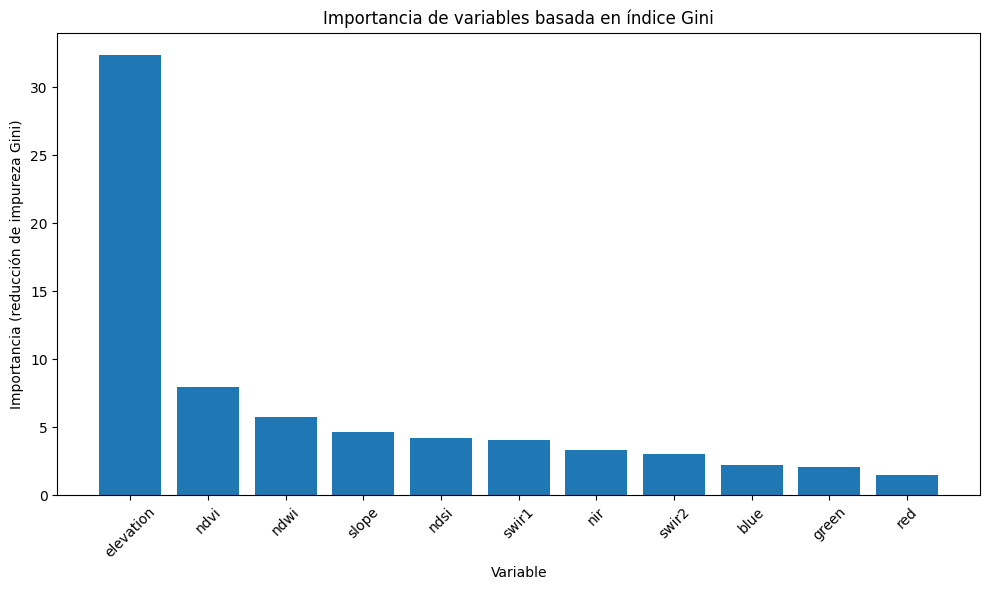

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1994 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,0,0,0,0,0,0,0
Vegetación,0,0,0,0,0,0,0
Cultivos,0,0,0,0,0,0,0
Nieve,0,0,0,121,0,0,0
Agua,0,0,0,0,0,0,0
Suelo,0,0,0,0,0,0,0
Suelo 2,0,0,0,0,0,0,97



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0]
1,Vegetación,[0]
2,Cultivos,[0]
3,Nieve,[1]
4,Agua,[0]
5,Suelo,[0]
6,Suelo 2,[1]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0, 0, 0, 1, 0, 0, 1]"
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 1.0000
Coeficiente Kappa: 1.0000
Clasificación para el año 1994 completada con éxito

=== Procesando año de prueba: 1985 ===
Pocas imágenes disponibles para 1985. Aumentando umbral de nubes a 50%
Número de imágenes para el año 1985: 3
Umbral de nubes utilizado: 50%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 208, 1: 210, 2: 250, 3: 250, 4: 223, 5: 125, 6: 250}

=== Validación cruzada para el año 1985 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9248366013071896, 0.8266666666666667, 0.9147540983606557, 0.8971631205673759, 0.8978328173374613]
Kappas por fold: [0.9115329017660738, 0.796689691124723, 0.8993105374760338, 0.8792719113066328, 0.8798945316461401]
Accuracy promedio: 0.8923
Kappa promedio: 0.8733
Entrenando clasificador final...

=== Importancia de variables 

,Variable,Importancia
1,elevation,109.697280
8,slope,54.385969
3,ndsi,38.246642
5,ndwi,37.208735
0,blue,31.768331
2,green,28.876142
4,ndvi,27.777664
7,red,27.097590
9,swir1,22.955166
10,swir2,21.783274


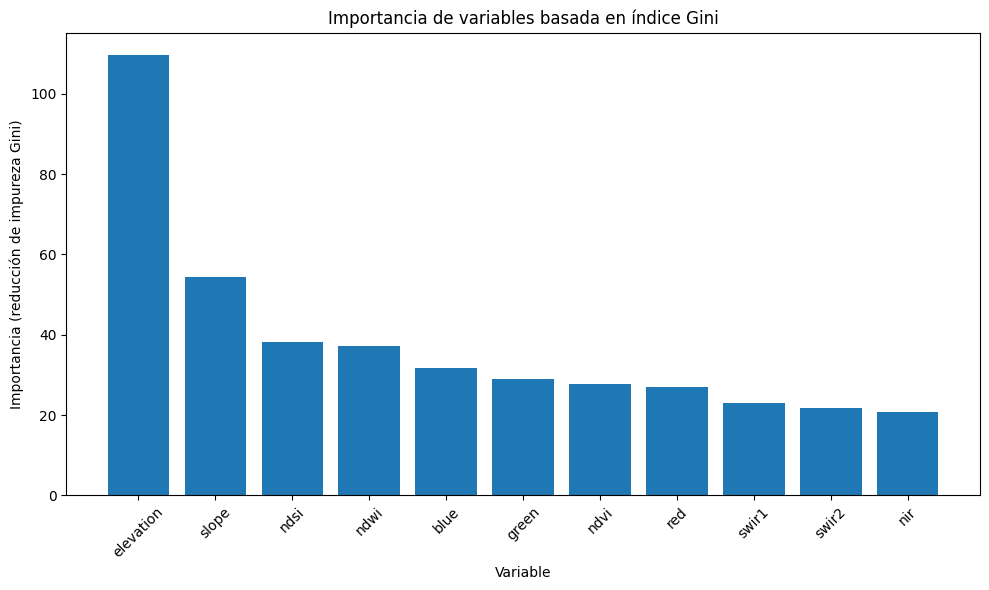

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1985 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,196,0,12,0,0,0,0
Vegetación,9,198,0,0,0,0,3
Cultivos,19,0,231,0,0,0,0
Nieve,0,0,0,248,0,0,2
Agua,2,0,0,0,221,0,0
Suelo,1,7,1,0,0,116,0
Suelo 2,0,11,0,5,0,0,234



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.9423076923076923]
1,Vegetación,[0.9428571428571428]
2,Cultivos,[0.924]
3,Nieve,[0.992]
4,Agua,[0.9910313901345291]
5,Suelo,[0.928]
6,Suelo 2,[0.936]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.8634361233480177, 0.9166666666666666, 0.946..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9525
Coeficiente Kappa: 0.9443
Clasificación para el año 1985 completada con éxito

=== Procesando año de prueba: 1990 ===
Pocas imágenes disponibles para 1990. Aumentando umbral de nubes a 50%
Número de imágenes para el año 1990: 3
Umbral de nubes utilizado: 50%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 2 clases en los datos de entrenamiento
Distribución de clases: {3: 121, 6: 109}

=== Validación cruzada para el año 1990 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9444444444444444, 0.975, 0.9, 0.9743589743589743, 0.9574468085106383]
Kappas por fold: [0.8888888888888888, 0.9459459459459459, 0.7980613893376414, 0.9475100942126514, 0.9101338432122372]
Accuracy promedio: 0.9503
Kappa promedio: 0.8981
Entrenando clasificador final...

=== Importancia de variables para el año 1990 ===
Importancia de variables (basada en reducción 

,Variable,Importancia
3,ndsi,11.507404
1,elevation,10.446132
0,blue,9.896308
2,green,7.364884
7,red,3.648418
4,ndvi,2.961613
5,ndwi,2.798779
6,nir,1.504114
10,swir2,0.822303
8,slope,0.620334


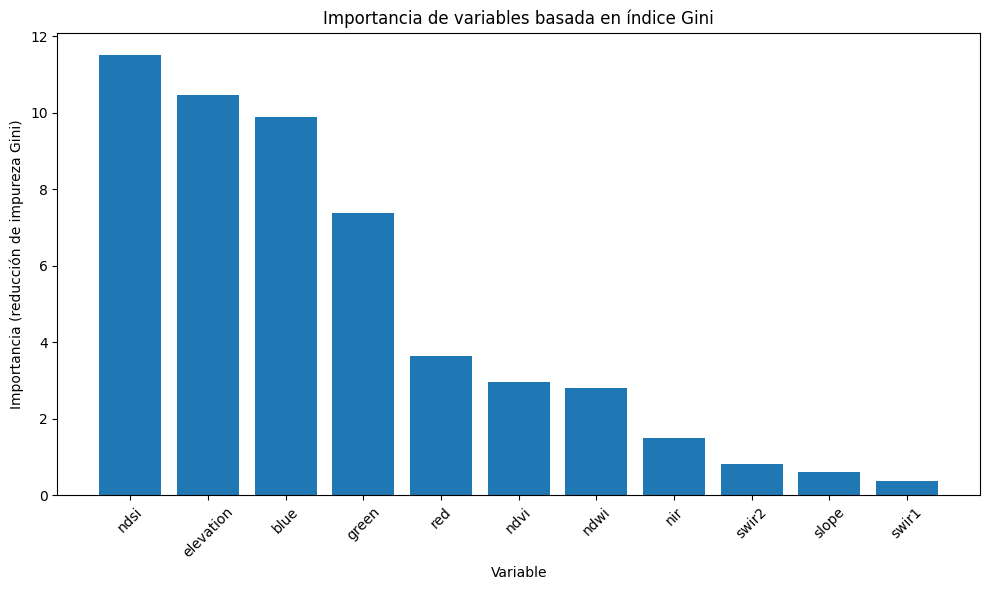

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1990 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,0,0,0,0,0,0,0
Vegetación,0,0,0,0,0,0,0
Cultivos,0,0,0,0,0,0,0
Nieve,0,0,0,121,0,0,0
Agua,0,0,0,0,0,0,0
Suelo,0,0,0,0,0,0,0
Suelo 2,0,0,0,3,0,0,106



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0]
1,Vegetación,[0]
2,Cultivos,[0]
3,Nieve,[1]
4,Agua,[0]
5,Suelo,[0]
6,Suelo 2,[0.9724770642201835]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0, 0, 0, 0.9758064516129032, 0, 0, 1]"
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9870
Coeficiente Kappa: 0.9738
Clasificación para el año 1990 completada con éxito

=== Procesando año de prueba: 2000 ===
Número de imágenes para el año 2000: 53
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2000 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.923943661971831, 0.8898550724637682, 0.9401709401709402, 0.8958333333333334, 0.8815426997245179]
Kappas por fold: [0.9112401377930882, 0.8715398559600216, 0.9298721315218632, 0.8783515392254221, 0.8616088448341593]
Accuracy promedio: 0.9063
Kappa promedio: 0.8905
Entrenando clasificador final...

=== Importancia de variables para el año 2000 ===
Importancia de variables (basada en reducción de 

,Variable,Importancia
1,elevation,104.362857
8,slope,59.680168
0,blue,40.417979
3,ndsi,37.454224
5,ndwi,34.612192
2,green,31.985933
7,red,25.887544
6,nir,24.377115
4,ndvi,24.107017
9,swir1,23.413929


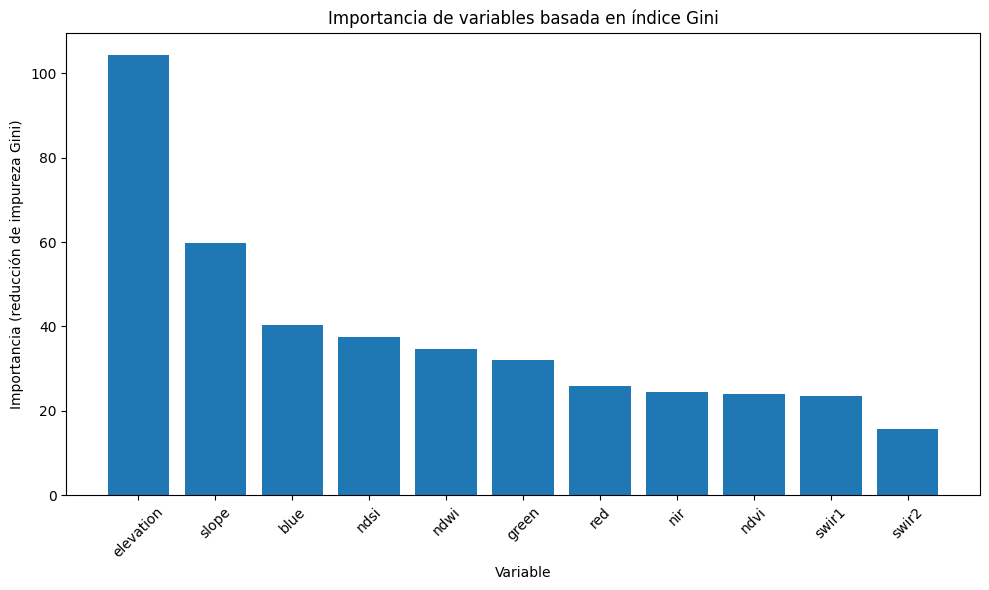

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2000 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,241,0,8,0,1,0,0
Vegetación,1,236,2,0,0,11,0
Cultivos,15,2,233,0,0,0,0
Nieve,0,0,0,248,0,0,2
Agua,1,0,0,0,249,0,0
Suelo,1,5,1,0,0,243,0
Suelo 2,0,11,0,5,0,1,233



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.964]
1,Vegetación,[0.944]
2,Cultivos,[0.932]
3,Nieve,[0.992]
4,Agua,[0.996]
5,Suelo,[0.972]
6,Suelo 2,[0.932]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9305019305019305, 0.9291338582677166, 0.954..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9617
Coeficiente Kappa: 0.9553
Clasificación para el año 2000 completada con éxito

=== Procesando año de prueba: 2010 ===
Número de imágenes para el año 2010: 74
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2010 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9464788732394366, 0.9217391304347826, 0.9458689458689459, 0.9166666666666666, 0.8980716253443526]
Kappas por fold: [0.9375295218160431, 0.9086630386821591, 0.9365558050154116, 0.902656057611721, 0.8809107917113698]
Accuracy promedio: 0.9258
Kappa promedio: 0.9133
Entrenando clasificador final...

=== Importancia de variables para el año 2010 ===
Importancia de variables (basada en reducción de 

,Variable,Importancia
1,elevation,92.376302
8,slope,56.236071
7,red,33.040905
0,blue,30.659871
5,ndwi,29.707701
2,green,26.250055
4,ndvi,24.878339
6,nir,24.770645
3,ndsi,24.655046
10,swir2,20.382928


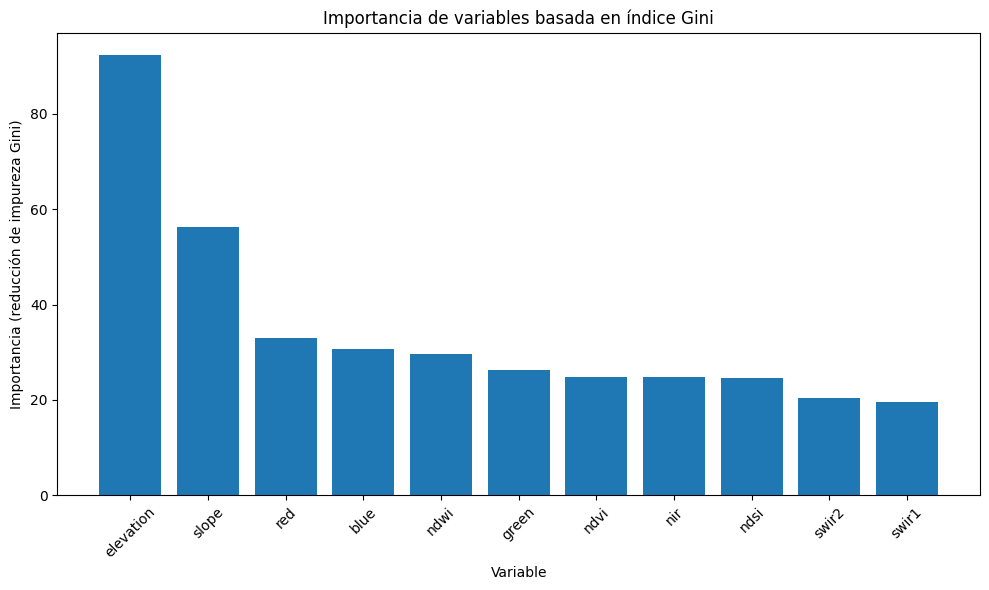

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2010 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,249,0,1,0,0,0,0
Vegetación,4,234,1,0,0,10,1
Cultivos,5,2,243,0,0,0,0
Nieve,0,0,0,247,0,0,3
Agua,1,0,0,0,249,0,0
Suelo,0,7,1,0,0,241,1
Suelo 2,0,9,0,3,0,1,237



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.996]
1,Vegetación,[0.936]
2,Cultivos,[0.972]
3,Nieve,[0.988]
4,Agua,[0.996]
5,Suelo,[0.964]
6,Suelo 2,[0.948]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9613899613899614, 0.9285714285714286, 0.987..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9714
Coeficiente Kappa: 0.9667
Clasificación para el año 2010 completada con éxito

=== Resumen de prueba inicial ===
Años clasificados con éxito: [1994, 1985, 1990, 2000, 2010]
Años con problemas: []

¿Deseas continuar con el procesamiento de todos los años? (s/n): s

=== Procesando años 1986 a 1991 ===


Iniciando procesamiento para el año 1986
Número de imágenes para el año 1986: 33
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 1986 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.8985915492957747, 0.8724637681159421, 0.9230769230769231, 0.8958333333333334, 0.8953168044077136]
Kappas por fold: [0.8816513251717816, 0.8512173128944995, 0.9099195863353

,Variable,Importancia
1,elevation,102.392851
8,slope,62.558370
0,blue,39.369965
2,green,38.636448
7,red,31.505507
5,ndwi,30.058544
4,ndvi,27.636388
3,ndsi,24.328996
6,nir,23.889249
10,swir2,21.835843


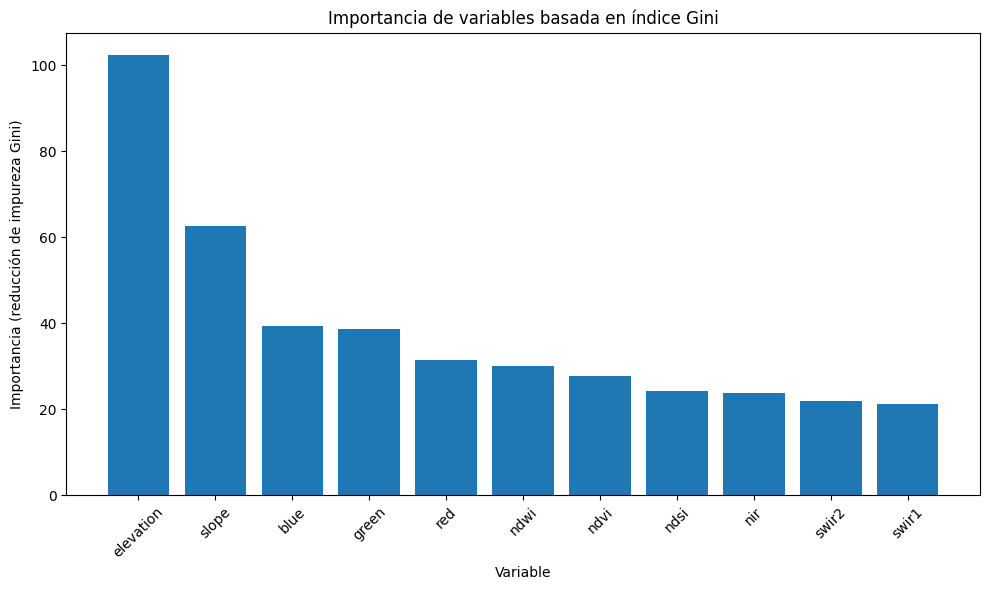

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1986 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,235,1,14,0,0,0,0
Vegetación,6,227,2,0,0,11,4
Cultivos,20,1,229,0,0,0,0
Nieve,0,0,0,250,0,0,0
Agua,2,0,0,0,248,0,0
Suelo,2,6,1,0,0,241,0
Suelo 2,0,10,0,5,0,1,234



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.94]
1,Vegetación,[0.908]
2,Cultivos,[0.916]
3,Nieve,[1]
4,Agua,[0.992]
5,Suelo,[0.964]
6,Suelo 2,[0.936]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.8867924528301887, 0.926530612244898, 0.9308..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9509
Coeficiente Kappa: 0.9427
Clasificación para el año 1986 completada con éxito

Iniciando procesamiento para el año 1987
Número de imágenes para el año 1987: 19
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 1987 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9014084507042254, 0.8898550724637682, 0.9287749287749287, 0.9077380952380952, 0.8925619834710744]
Kappas por fold: [0.8849611599248197, 0.8714605067064084, 0.9165033208365844, 0.8922453033187121, 0.874441251596424]
Accuracy promedio: 0.9041
Kappa promedio: 0.8879
Entrenando clasificador final...

=== Importancia de variables para el año 1987 ===
Importancia de variables (basada en reducción d

,Variable,Importancia
1,elevation,116.460951
8,slope,61.738979
5,ndwi,37.451569
0,blue,34.918981
3,ndsi,32.178756
4,ndvi,32.033301
2,green,30.611371
9,swir1,26.935933
7,red,26.716695
10,swir2,21.669839


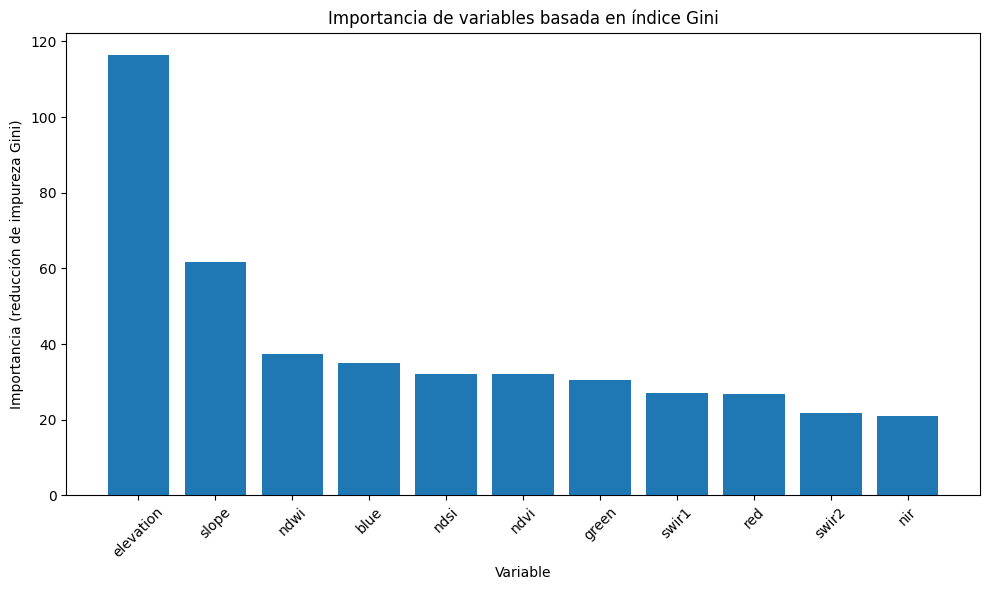

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1987 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,237,1,12,0,0,0,0
Vegetación,6,230,2,0,0,10,2
Cultivos,18,1,231,0,0,0,0
Nieve,0,0,0,248,0,0,2
Agua,2,0,0,0,248,0,0
Suelo,2,5,0,0,0,243,0
Suelo 2,0,9,0,3,0,0,238



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.948]
1,Vegetación,[0.92]
2,Cultivos,[0.924]
3,Nieve,[0.992]
4,Agua,[0.992]
5,Suelo,[0.972]
6,Suelo 2,[0.952]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.8943396226415095, 0.9349593495934959, 0.942..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9571
Coeficiente Kappa: 0.9500
Clasificación para el año 1987 completada con éxito

Iniciando procesamiento para el año 1988
Número de imágenes para el año 1988: 7
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 2 clases en los datos de entrenamiento
Distribución de clases: {3: 121, 6: 103}

=== Validación cruzada para el año 1988 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [1, 1, 0.9795918367346939, 0.9743589743589743, 0.9782608695652174]
Kappas por fold: [1, 1, 0.9580838323353293, 0.9465020576131686, 0.9539078156312626]
Accuracy promedio: 0.9864
Kappa promedio: 0.9717
Entrenando clasificador final...

=== Importancia de variables para el año 1988 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
2,green,11.601264
0,blue,10.848347
1,elevation,6.449477
7,red,6.045499
3,ndsi,6.015879
4,ndvi,2.650427
6,nir,2.118215
5,ndwi,1.363724
9,swir1,0.323014
10,swir2,0.020678


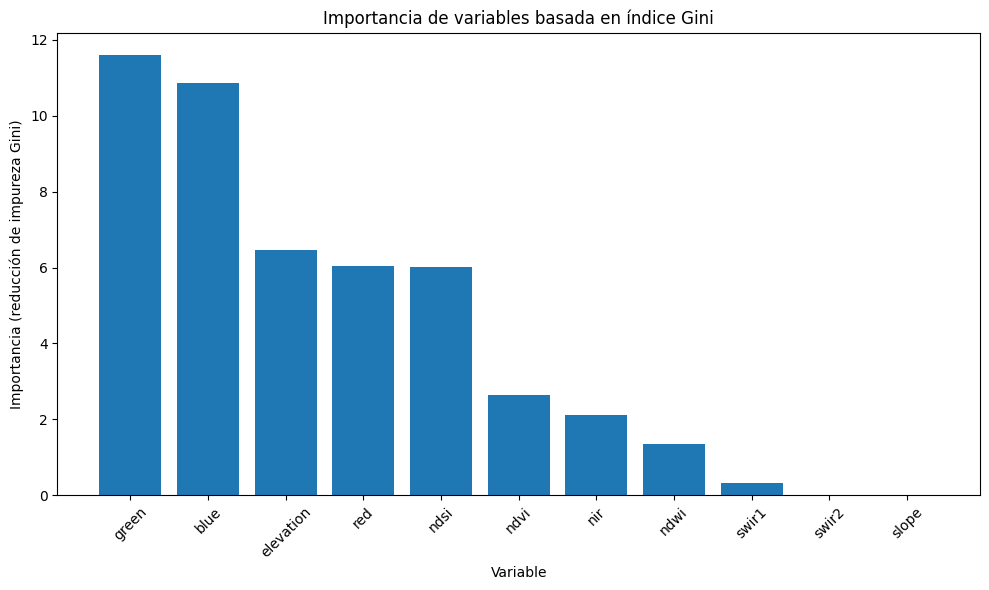

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1988 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,0,0,0,0,0,0,0
Vegetación,0,0,0,0,0,0,0
Cultivos,0,0,0,0,0,0,0
Nieve,0,0,0,121,0,0,0
Agua,0,0,0,0,0,0,0
Suelo,0,0,0,0,0,0,0
Suelo 2,0,0,0,3,0,0,100



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0]
1,Vegetación,[0]
2,Cultivos,[0]
3,Nieve,[1]
4,Agua,[0]
5,Suelo,[0]
6,Suelo 2,[0.970873786407767]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0, 0, 0, 0.9758064516129032, 0, 0, 1]"
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9866
Coeficiente Kappa: 0.9730
Clasificación para el año 1988 completada con éxito

Iniciando procesamiento para el año 1989
Pocas imágenes disponibles para 1989. Aumentando umbral de nubes a 50%
Número de imágenes para el año 1989: 5
Umbral de nubes utilizado: 50%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 2 clases en los datos de entrenamiento
Distribución de clases: {3: 134, 6: 159}

=== Validación cruzada para el año 1989 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9142857142857143, 0.9777777777777777, 0.9491525423728814, 0.9824561403508771, 0.9838709677419355]
Kappas por fold: [0.8235294117647058, 0.9508196721311475, 0.8982173663024727, 0.9647495361781075, 0.967741935483871]
Accuracy promedio: 0.9615
Kappa promedio: 0.9210
Entrenando clasificador final...

=== Importancia de variables para el año 1989 ===
Importancia de va

,Variable,Importancia
1,elevation,30.717157
0,blue,8.711475
8,slope,6.206067
3,ndsi,5.963825
7,red,4.862443
2,green,4.026442
9,swir1,1.982804
6,nir,1.937577
4,ndvi,1.568772
5,ndwi,1.246130


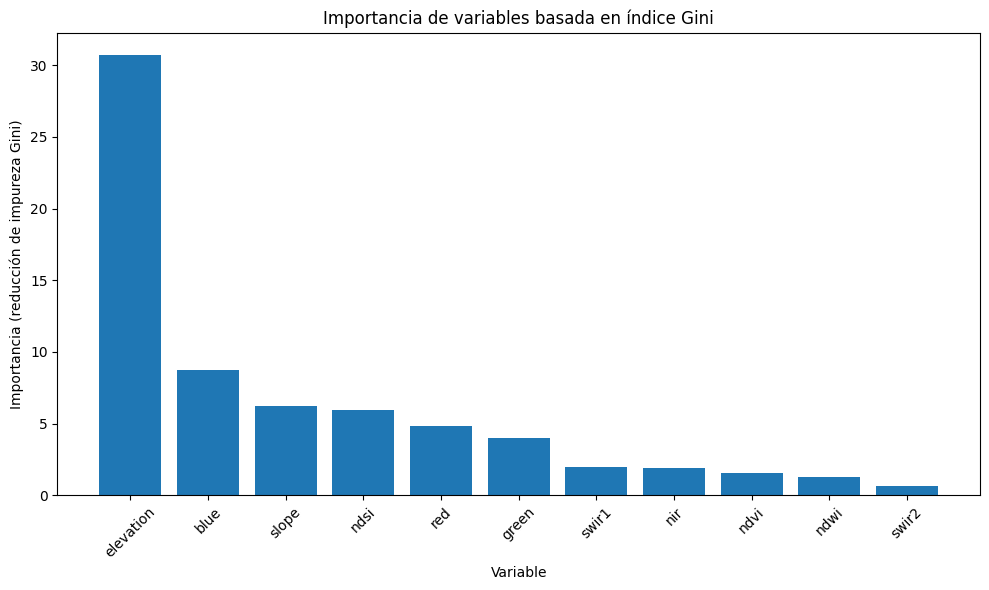

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1989 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,0,0,0,0,0,0,0
Vegetación,0,0,0,0,0,0,0
Cultivos,0,0,0,0,0,0,0
Nieve,0,0,0,132,0,0,2
Agua,0,0,0,0,0,0,0
Suelo,0,0,0,0,0,0,0
Suelo 2,0,0,0,3,0,0,156



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0]
1,Vegetación,[0]
2,Cultivos,[0]
3,Nieve,[0.9850746268656716]
4,Agua,[0]
5,Suelo,[0]
6,Suelo 2,[0.9811320754716981]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0, 0, 0, 0.9777777777777777, 0, 0, 0.98734177..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9829
Coeficiente Kappa: 0.9656
Clasificación para el año 1989 completada con éxito

Iniciando procesamiento para el año 1991
Número de imágenes para el año 1991: 3
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 2 clases en los datos de entrenamiento
Distribución de clases: {3: 121, 6: 112}

=== Validación cruzada para el año 1991 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9814814814814815, 0.95, 0.9803921568627451, 0.9512195121951219, 1]
Kappas por fold: [0.962962962962963, 0.896103896103896, 0.9605568445475637, 0.8997555012224938, 1]
Accuracy promedio: 0.9726
Kappa promedio: 0.9439
Entrenando clasificador final...

=== Importancia de variables para el año 1991 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,16.931062
4,ndvi,11.762751
5,ndwi,7.240424
3,ndsi,5.799585
0,blue,4.702999
2,green,2.503741
7,red,1.084828
9,swir1,0.789670
8,slope,0.648262
6,nir,0.461244


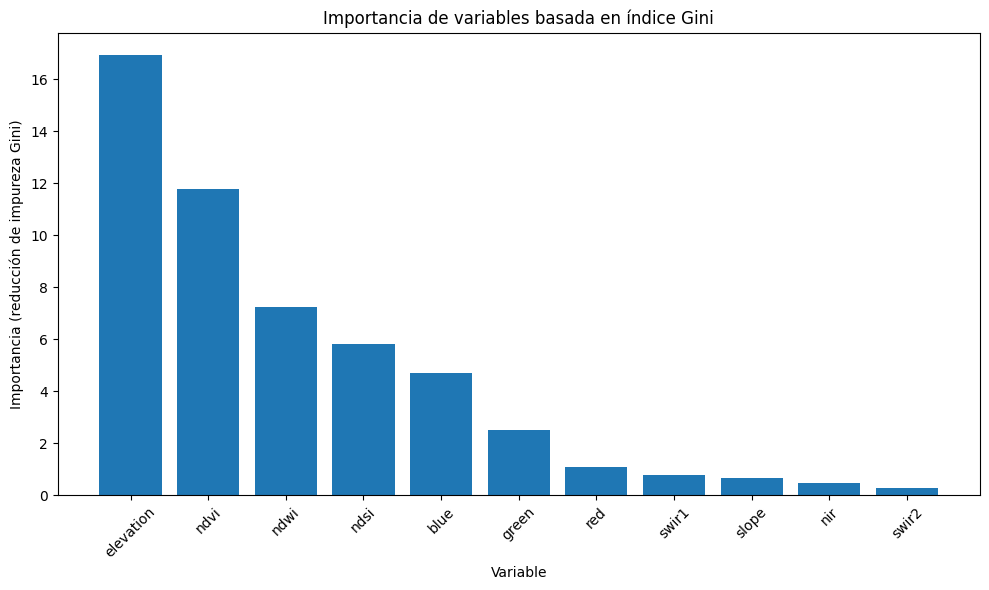

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1991 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,0,0,0,0,0,0,0
Vegetación,0,0,0,0,0,0,0
Cultivos,0,0,0,0,0,0,0
Nieve,0,0,0,121,0,0,0
Agua,0,0,0,0,0,0,0
Suelo,0,0,0,0,0,0,0
Suelo 2,0,0,0,0,0,0,112



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0]
1,Vegetación,[0]
2,Cultivos,[0]
3,Nieve,[1]
4,Agua,[0]
5,Suelo,[0]
6,Suelo 2,[1]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0, 0, 0, 1, 0, 0, 1]"
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 1.0000
Coeficiente Kappa: 1.0000
Clasificación para el año 1991 completada con éxito

=== Procesando años 1992 a 1997 ===


Iniciando procesamiento para el año 1992
Número de imágenes para el año 1992: 3
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 2 clases en los datos de entrenamiento
Distribución de clases: {3: 121, 6: 111}

=== Validación cruzada para el año 1992 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [1, 1, 0.9803921568627451, 0.9743589743589743, 0.9791666666666666]
Kappas por fold: [1, 1, 0.9602494154325798, 0.9465020576131686, 0.9568345323741007]
Accuracy promedio: 0.9868
Kappa promedio: 0.9727
Entrenando clasificador final...

=== Importancia de variables para el año 1992 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
3,ndsi,9.992117
1,elevation,8.916363
6,nir,8.603385
2,green,7.353837
7,red,6.682210
0,blue,4.732661
4,ndvi,1.540119
5,ndwi,0.905779
10,swir2,0.314927
8,slope,0.175290


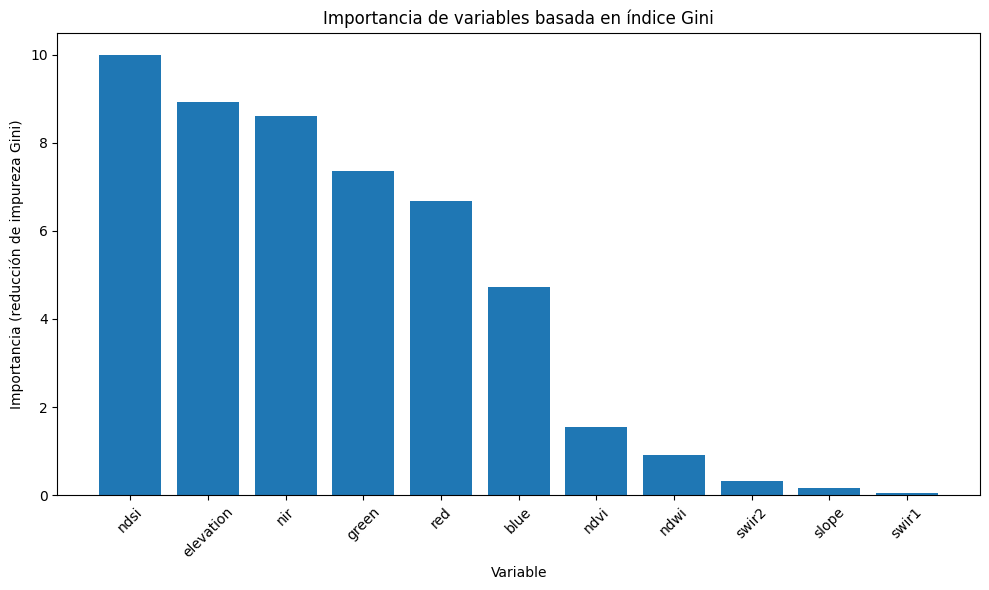

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1992 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,0,0,0,0,0,0,0
Vegetación,0,0,0,0,0,0,0
Cultivos,0,0,0,0,0,0,0
Nieve,0,0,0,121,0,0,0
Agua,0,0,0,0,0,0,0
Suelo,0,0,0,0,0,0,0
Suelo 2,0,0,0,3,0,0,108



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0]
1,Vegetación,[0]
2,Cultivos,[0]
3,Nieve,[1]
4,Agua,[0]
5,Suelo,[0]
6,Suelo 2,[0.972972972972973]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0, 0, 0, 0.9758064516129032, 0, 0, 1]"
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9871
Coeficiente Kappa: 0.9741
Clasificación para el año 1992 completada con éxito

Iniciando procesamiento para el año 1993
Número de imágenes para el año 1993: 3
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 158, 1: 122, 2: 193, 3: 241, 4: 132, 5: 128, 6: 203}

=== Validación cruzada para el año 1993 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9184549356223176, 0.8724279835390947, 0.9079497907949791, 0.8873873873873874, 0.9041666666666667]
Kappas por fold: [0.903099417764742, 0.8497486835806606, 0.8905905364351409, 0.8671613212063188, 0.8866250410778836]
Accuracy promedio: 0.8981
Kappa promedio: 0.8794
Entrenando clasificador final...

=== Importancia de variables para el año 1993 ===
Importancia de variables (basada en reducción de

,Variable,Importancia
1,elevation,98.968857
8,slope,54.899834
0,blue,32.444972
2,green,26.933597
5,ndwi,24.955438
4,ndvi,22.514859
7,red,20.961746
9,swir1,20.060356
3,ndsi,19.641688
6,nir,17.700065


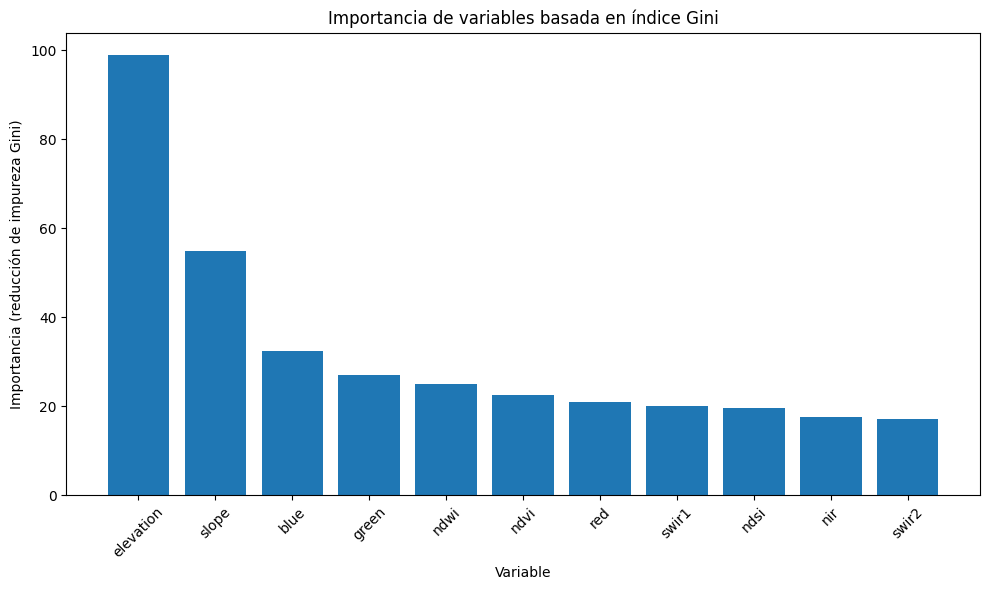

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1993 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,151,0,6,0,1,0,0
Vegetación,1,110,2,0,0,7,2
Cultivos,8,1,184,0,0,0,0
Nieve,0,0,0,240,0,0,1
Agua,2,0,0,0,130,0,0
Suelo,1,6,0,0,0,121,0
Suelo 2,0,6,0,4,0,0,193



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.9556962025316456]
1,Vegetación,[0.9016393442622951]
2,Cultivos,[0.9533678756476683]
3,Nieve,[0.995850622406639]
4,Agua,[0.9848484848484849]
5,Suelo,[0.9453125]
6,Suelo 2,[0.9507389162561576]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9263803680981595, 0.8943089430894309, 0.958..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9592
Coeficiente Kappa: 0.9519
Clasificación para el año 1993 completada con éxito

Iniciando procesamiento para el año 1995
Pocas imágenes disponibles para 1995. Aumentando umbral de nubes a 50%
Número de imágenes para el año 1995: 3
Umbral de nubes utilizado: 50%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
ADVERTENCIA: Solo se encontró 1 clase(s) en los datos de entrenamiento
Clases encontradas: [6]
Distribución: {6: 74}
Intentando con parámetros ajustados (intento 1 de 2)...
Pocas imágenes disponibles para 1995. Aumentando umbral de nubes a 50%
Número de imágenes para el año 1995: 3
Umbral de nubes utilizado: 50%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
ADVERTENCIA: Solo se encontró 1 clase(s) en los datos de entrenamiento
Clases encontradas: [6]
Distribución: {6: 74}
Intenta

,Variable,Importancia
1,elevation,96.546284
8,slope,55.892207
4,ndvi,30.076651
5,ndwi,28.089340
6,nir,24.616899
10,swir2,24.557799
9,swir1,23.877726
3,ndsi,23.805280
2,green,20.323285
7,red,20.064995


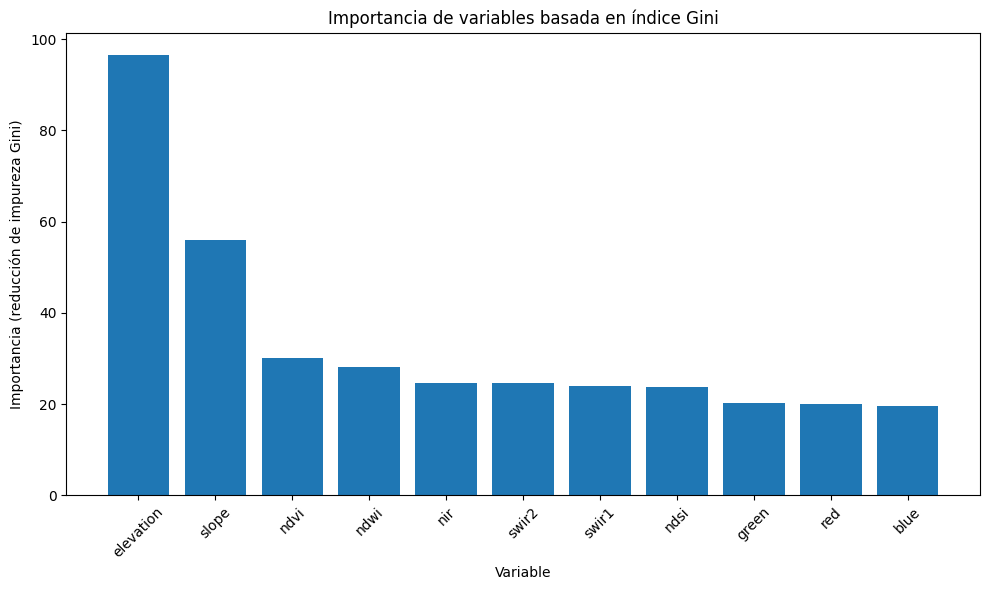

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1996 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,156,0,6,0,1,0,0
Vegetación,2,108,0,0,0,12,2
Cultivos,12,0,178,0,2,1,0
Nieve,0,0,0,240,0,0,1
Agua,1,0,0,0,142,0,0
Suelo,1,2,0,0,0,153,0
Suelo 2,0,5,0,4,0,0,194



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.9570552147239264]
1,Vegetación,[0.8709677419354839]
2,Cultivos,[0.9222797927461139]
3,Nieve,[0.995850622406639]
4,Agua,[0.993006993006993]
5,Suelo,[0.9807692307692307]
6,Suelo 2,[0.9556650246305419]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9069767441860465, 0.9391304347826087, 0.967..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9575
Coeficiente Kappa: 0.9500
Clasificación para el año 1996 completada con éxito

Iniciando procesamiento para el año 1997
Pocas imágenes disponibles para 1997. Aumentando umbral de nubes a 50%
Número de imágenes para el año 1997: 3
Umbral de nubes utilizado: 50%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 2 clases en los datos de entrenamiento
Distribución de clases: {3: 121, 6: 108}

=== Validación cruzada para el año 1997 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9622641509433962, 1, 0.9019607843137255, 0.975, 0.9565217391304348]
Kappas por fold: [0.9246088193456614, 1, 0.802784222737819, 0.9484536082474226, 0.9068825910931175]
Accuracy promedio: 0.9591
Kappa promedio: 0.9165
Entrenando clasificador final...

=== Importancia de variables para el año 1997 ===
Importancia de variables (basada en reducción de impureza Gini):

,Variable,Importancia
1,elevation,26.370731
2,green,8.725963
7,red,6.973216
8,slope,4.547233
0,blue,3.650638
4,ndvi,3.643912
6,nir,3.460974
9,swir1,2.542424
5,ndwi,1.829099
10,swir2,1.674786


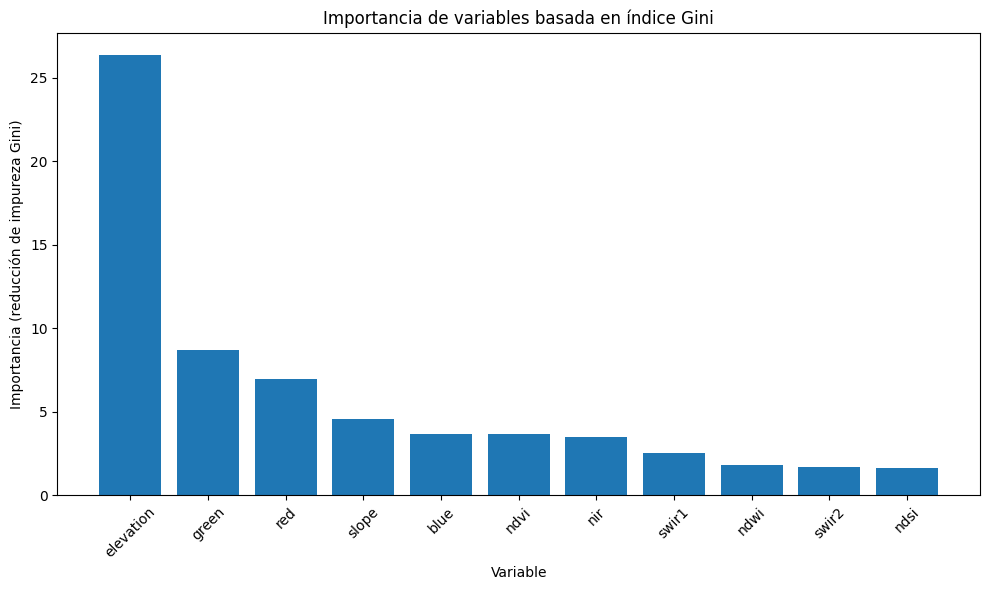

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1997 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,0,0,0,0,0,0,0
Vegetación,0,0,0,0,0,0,0
Cultivos,0,0,0,0,0,0,0
Nieve,0,0,0,121,0,0,0
Agua,0,0,0,0,0,0,0
Suelo,0,0,0,0,0,0,0
Suelo 2,0,0,0,0,0,0,108



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0]
1,Vegetación,[0]
2,Cultivos,[0]
3,Nieve,[1]
4,Agua,[0]
5,Suelo,[0]
6,Suelo 2,[1]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0, 0, 0, 1, 0, 0, 1]"
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 1.0000
Coeficiente Kappa: 1.0000
Clasificación para el año 1997 completada con éxito

=== Procesando años 1998 a 2003 ===


Iniciando procesamiento para el año 1998
Número de imágenes para el año 1998: 21
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 1998 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9352112676056338, 0.8927536231884058, 0.905982905982906, 0.8809523809523809, 0.9035812672176309]
Kappas por fold: [0.9243876464323747, 0.8748872858431018, 0.8898315563206802, 0.860967434931932, 0.8873130754084403]
Accuracy promedio: 0.9037
Kappa promedio: 0.8875
Entrenando clasificador final...

=== Importancia de variables para el año 1998 ===
Importanci

,Variable,Importancia
1,elevation,126.848821
8,slope,62.978286
6,nir,41.035711
5,ndwi,40.441944
0,blue,35.966059
2,green,35.000750
10,swir2,34.047201
4,ndvi,33.575503
7,red,30.084489
3,ndsi,22.123795


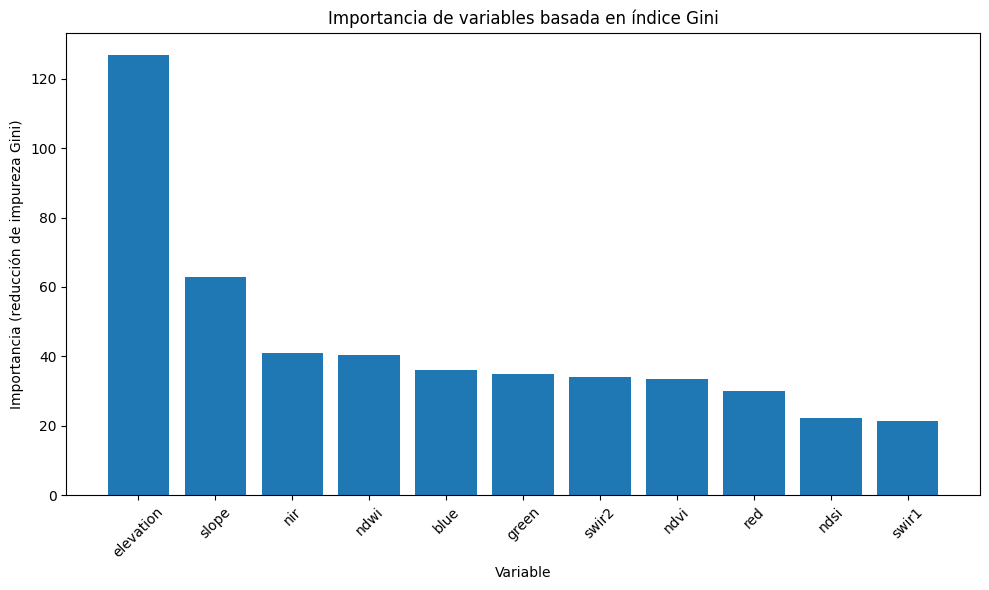

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1998 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,238,0,11,0,1,0,0
Vegetación,1,233,1,0,0,12,3
Cultivos,12,1,237,0,0,0,0
Nieve,0,0,0,249,0,0,1
Agua,4,1,0,0,245,0,0
Suelo,1,3,1,0,0,245,0
Suelo 2,0,14,0,5,0,0,231



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.952]
1,Vegetación,[0.932]
2,Cultivos,[0.948]
3,Nieve,[0.996]
4,Agua,[0.98]
5,Suelo,[0.98]
6,Suelo 2,[0.924]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9296875, 0.9246031746031746, 0.948, 0.98031..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9589
Coeficiente Kappa: 0.9520
Clasificación para el año 1998 completada con éxito

Iniciando procesamiento para el año 1999
Número de imágenes para el año 1999: 17
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 1999 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9183098591549296, 0.881159420289855, 0.9458689458689459, 0.9047619047619048, 0.9366391184573003]
Kappas por fold: [0.9046609188483372, 0.861395549371405, 0.936521987435751, 0.8887463267248872, 0.9259466219632263]
Accuracy promedio: 0.9173
Kappa promedio: 0.9035
Entrenando clasificador final...

=== Importancia de variables para el año 1999 ===
Importancia de variables (basada en reducción de 

,Variable,Importancia
1,elevation,102.173928
8,slope,63.520731
0,blue,37.353395
2,green,34.499590
3,ndsi,33.794454
7,red,30.459491
9,swir1,26.072555
6,nir,25.134073
10,swir2,24.848118
5,ndwi,23.448141


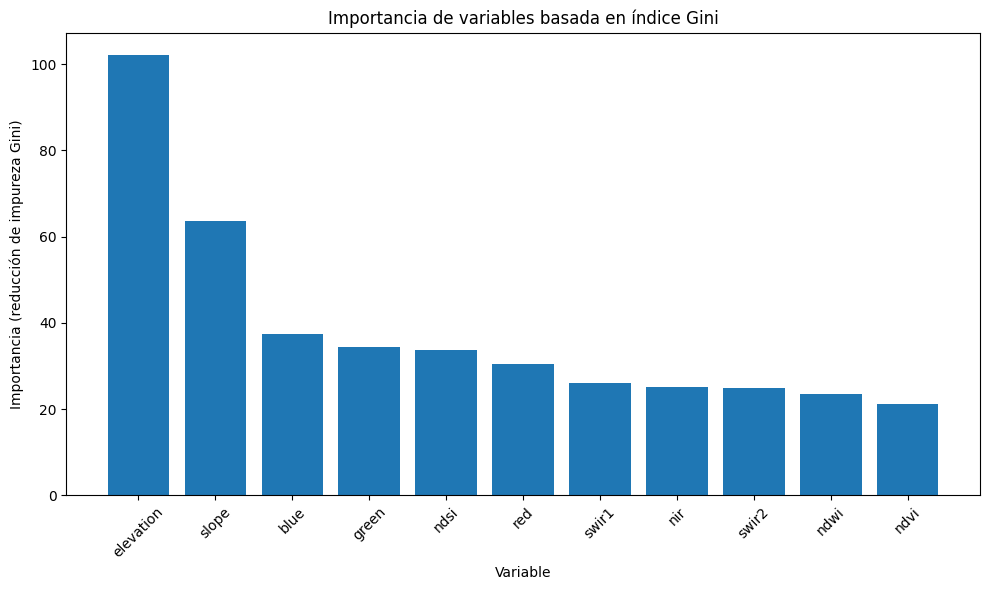

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 1999 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,244,0,6,0,0,0,0
Vegetación,0,236,3,0,0,10,1
Cultivos,11,1,236,0,1,1,0
Nieve,0,0,0,247,0,0,3
Agua,0,0,0,0,250,0,0
Suelo,0,2,2,0,1,245,0
Suelo 2,0,11,0,3,1,0,235



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.976]
1,Vegetación,[0.944]
2,Cultivos,[0.944]
3,Nieve,[0.988]
4,Agua,[1]
5,Suelo,[0.98]
6,Suelo 2,[0.94]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9568627450980393, 0.944, 0.9554655870445344..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9674
Coeficiente Kappa: 0.9620
Clasificación para el año 1999 completada con éxito

Iniciando procesamiento para el año 2001
Número de imágenes para el año 2001: 48
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2001 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9380281690140845, 0.9130434782608695, 0.9572649572649573, 0.8958333333333334, 0.8980716253443526]
Kappas por fold: [0.9276577219129484, 0.8985144874246213, 0.9499234346912183, 0.8783867631851087, 0.8809445719908167]
Accuracy promedio: 0.9204
Kappa promedio: 0.9071
Entrenando clasificador final...

=== Importancia de variables para el año 2001 ===
Importancia de variables (basada en reducción 

,Variable,Importancia
1,elevation,94.897179
8,slope,63.973602
0,blue,39.988647
2,green,33.532716
5,ndwi,30.807750
3,ndsi,29.915535
7,red,26.663537
4,ndvi,23.532132
6,nir,22.929779
10,swir2,22.131544


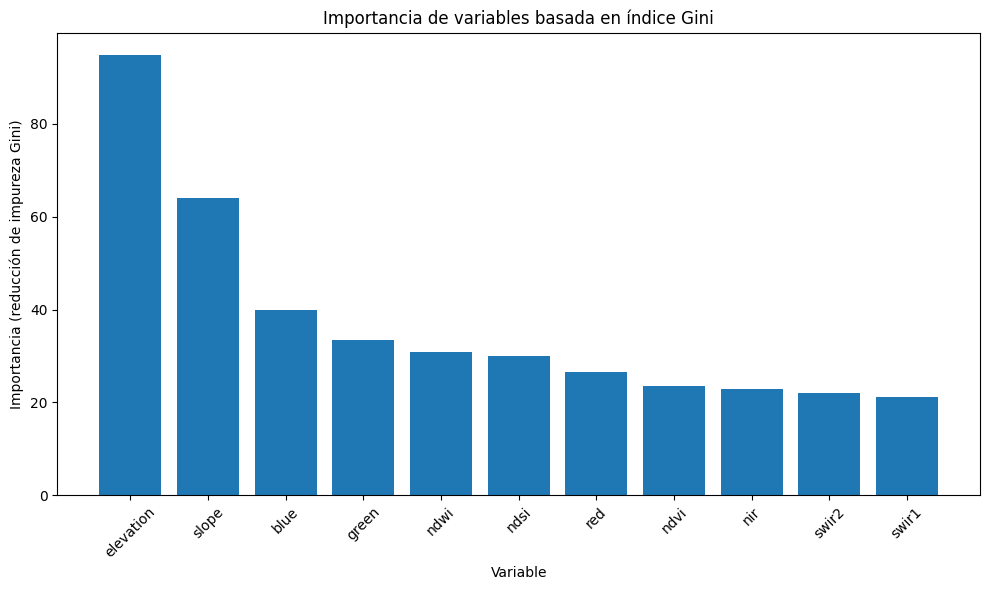

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2001 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,242,0,8,0,0,0,0
Vegetación,1,235,1,0,0,12,1
Cultivos,12,1,237,0,0,0,0
Nieve,0,0,0,249,0,0,1
Agua,2,0,0,0,248,0,0
Suelo,3,7,1,0,0,239,0
Suelo 2,0,10,0,4,0,1,235



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.968]
1,Vegetación,[0.94]
2,Cultivos,[0.948]
3,Nieve,[0.996]
4,Agua,[0.992]
5,Suelo,[0.956]
6,Suelo 2,[0.94]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9307692307692308, 0.9288537549407114, 0.959..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9629
Coeficiente Kappa: 0.9567
Clasificación para el año 2001 completada con éxito

Iniciando procesamiento para el año 2002
Número de imágenes para el año 2002: 40
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2002 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9267605633802817, 0.8927536231884058, 0.9715099715099715, 0.8988095238095238, 0.928374655647383]
Kappas por fold: [0.9145148742266513, 0.8749069029046294, 0.9665971964484541, 0.8818711999007322, 0.9162904556218792]
Accuracy promedio: 0.9236
Kappa promedio: 0.9108
Entrenando clasificador final...

=== Importancia de variables para el año 2002 ===
Importancia de variables (basada en reducción d

,Variable,Importancia
1,elevation,92.182046
8,slope,60.805584
5,ndwi,31.874065
0,blue,31.262171
4,ndvi,31.080334
3,ndsi,30.171412
7,red,29.866718
2,green,29.604293
6,nir,26.028981
9,swir1,25.512224


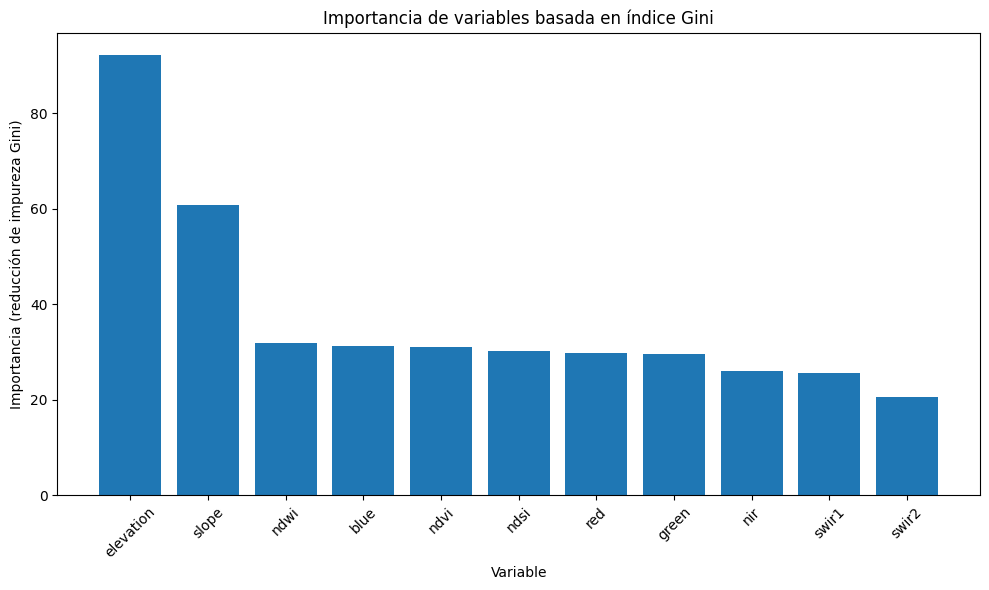

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2002 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,246,0,4,0,0,0,0
Vegetación,1,242,1,0,0,5,1
Cultivos,11,2,237,0,0,0,0
Nieve,0,0,0,248,0,0,2
Agua,2,0,0,0,248,0,0
Suelo,2,4,1,0,0,243,0
Suelo 2,0,10,0,6,0,1,233



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.984]
1,Vegetación,[0.968]
2,Cultivos,[0.948]
3,Nieve,[0.992]
4,Agua,[0.992]
5,Suelo,[0.972]
6,Suelo 2,[0.932]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9389312977099237, 0.937984496124031, 0.9753..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9697
Coeficiente Kappa: 0.9647
Clasificación para el año 2002 completada con éxito

Iniciando procesamiento para el año 2003
Número de imágenes para el año 2003: 84
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2003 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9464788732394366, 0.9420289855072463, 0.9401709401709402, 0.9226190476190477, 0.9201101928374655]
Kappas por fold: [0.9375104226500398, 0.9323648767864494, 0.9298374200426439, 0.9096185480617028, 0.9065852641293448]
Accuracy promedio: 0.9343
Kappa promedio: 0.9232
Entrenando clasificador final...

=== Importancia de variables para el año 2003 ===
Importancia de variables (basada en reducción 

,Variable,Importancia
1,elevation,94.219735
8,slope,55.072166
0,blue,42.682447
5,ndwi,29.969303
7,red,27.378500
3,ndsi,26.896558
2,green,24.469615
10,swir2,23.328534
6,nir,23.134056
4,ndvi,21.939977


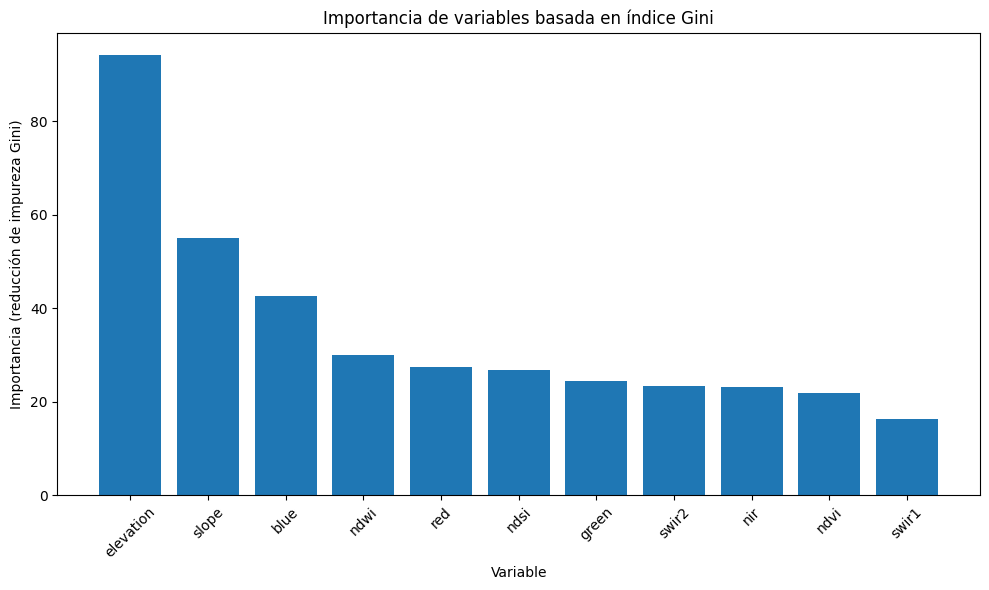

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2003 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,242,0,8,0,0,0,0
Vegetación,1,240,1,0,0,7,1
Cultivos,6,2,241,0,0,1,0
Nieve,0,0,0,248,0,0,2
Agua,2,0,0,0,248,0,0
Suelo,8,3,1,0,0,238,0
Suelo 2,0,7,0,5,0,1,237



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.968]
1,Vegetación,[0.96]
2,Cultivos,[0.964]
3,Nieve,[0.992]
4,Agua,[0.992]
5,Suelo,[0.952]
6,Suelo 2,[0.948]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9343629343629344, 0.9523809523809523, 0.960..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9680
Coeficiente Kappa: 0.9627
Clasificación para el año 2003 completada con éxito

=== Procesando años 2004 a 2008 ===


Iniciando procesamiento para el año 2004
Número de imágenes para el año 2004: 109
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2004 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9323943661971831, 0.9217391304347826, 0.9344729344729344, 0.9345238095238095, 0.9228650137741047]
Kappas por fold: [0.9210584834334, 0.9086791564953972, 0.9232458642327438, 0.9235328802408218, 0.9098344658730018]
Accuracy promedio: 0.9292
Kappa promedio: 0.9173
Entrenando clasificador final...

=== Importancia de variables para el año 2004 ===
Importanci

,Variable,Importancia
1,elevation,102.356822
8,slope,56.651130
7,red,31.274968
5,ndwi,29.686591
4,ndvi,29.482310
0,blue,28.685410
3,ndsi,26.620131
10,swir2,26.535138
2,green,23.291448
6,nir,23.026740


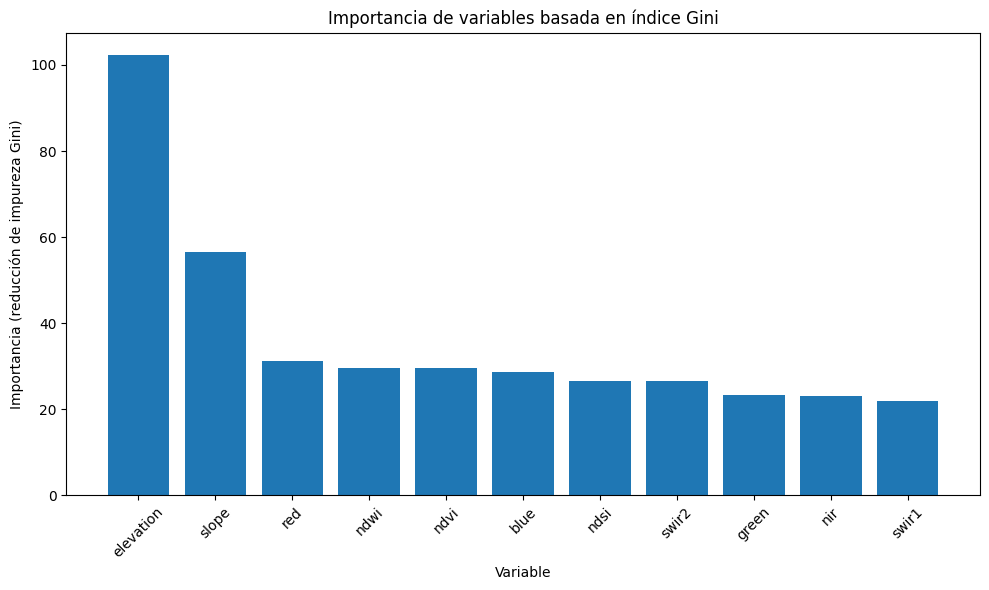

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2004 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,239,0,9,0,1,1,0
Vegetación,1,233,1,0,0,13,2
Cultivos,7,4,238,0,0,1,0
Nieve,0,0,0,246,0,0,4
Agua,4,1,0,0,245,0,0
Suelo,4,3,0,0,0,243,0
Suelo 2,0,10,0,4,0,1,235



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.956]
1,Vegetación,[0.932]
2,Cultivos,[0.952]
3,Nieve,[0.984]
4,Agua,[0.98]
5,Suelo,[0.972]
6,Suelo 2,[0.94]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9372549019607843, 0.9282868525896414, 0.959..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9594
Coeficiente Kappa: 0.9527
Clasificación para el año 2004 completada con éxito

Iniciando procesamiento para el año 2005
Número de imágenes para el año 2005: 116
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2005 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.923943661971831, 0.9333333333333333, 0.9487179487179487, 0.9196428571428571, 0.90633608815427]
Kappas por fold: [0.9111792723835647, 0.9222150335254676, 0.9398869669463948, 0.9061394251660562, 0.8906025634207309]
Accuracy promedio: 0.9264
Kappa promedio: 0.9140
Entrenando clasificador final...

=== Importancia de variables para el año 2005 ===
Importancia de variables (basada en reducción de

,Variable,Importancia
1,elevation,118.153739
8,slope,57.742879
0,blue,36.408783
2,green,34.733857
5,ndwi,32.718557
3,ndsi,28.577202
7,red,26.908591
6,nir,25.899013
4,ndvi,25.779665
9,swir1,23.611050


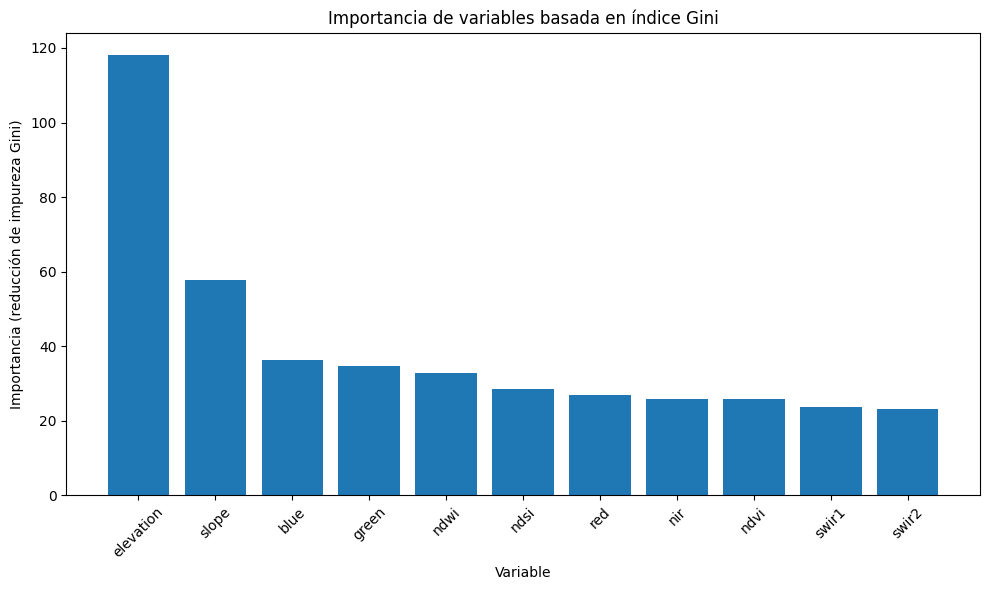

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2005 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,244,0,5,0,0,1,0
Vegetación,1,231,1,0,0,15,2
Cultivos,4,3,243,0,0,0,0
Nieve,0,0,0,248,0,0,2
Agua,1,0,0,0,249,0,0
Suelo,3,5,0,0,0,242,0
Suelo 2,0,9,0,5,0,1,235



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.976]
1,Vegetación,[0.924]
2,Cultivos,[0.972]
3,Nieve,[0.992]
4,Agua,[0.996]
5,Suelo,[0.968]
6,Suelo 2,[0.94]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9644268774703557, 0.9314516129032258, 0.975..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9669
Coeficiente Kappa: 0.9613
Clasificación para el año 2005 completada con éxito

Iniciando procesamiento para el año 2006
Número de imágenes para el año 2006: 113
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2006 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9492957746478873, 0.9188405797101449, 0.9344729344729344, 0.9196428571428571, 0.9090909090909091]
Kappas por fold: [0.9407697156204813, 0.9053126837874926, 0.9232020547945204, 0.906126799184611, 0.8937843589288882]
Accuracy promedio: 0.9263
Kappa promedio: 0.9138
Entrenando clasificador final...

=== Importancia de variables para el año 2006 ===
Importancia de variables (basada en reducción 

,Variable,Importancia
1,elevation,97.540466
8,slope,56.848161
0,blue,32.063071
2,green,31.208338
5,ndwi,31.082492
6,nir,27.494980
7,red,27.215245
10,swir2,24.145739
3,ndsi,22.567863
4,ndvi,21.849345


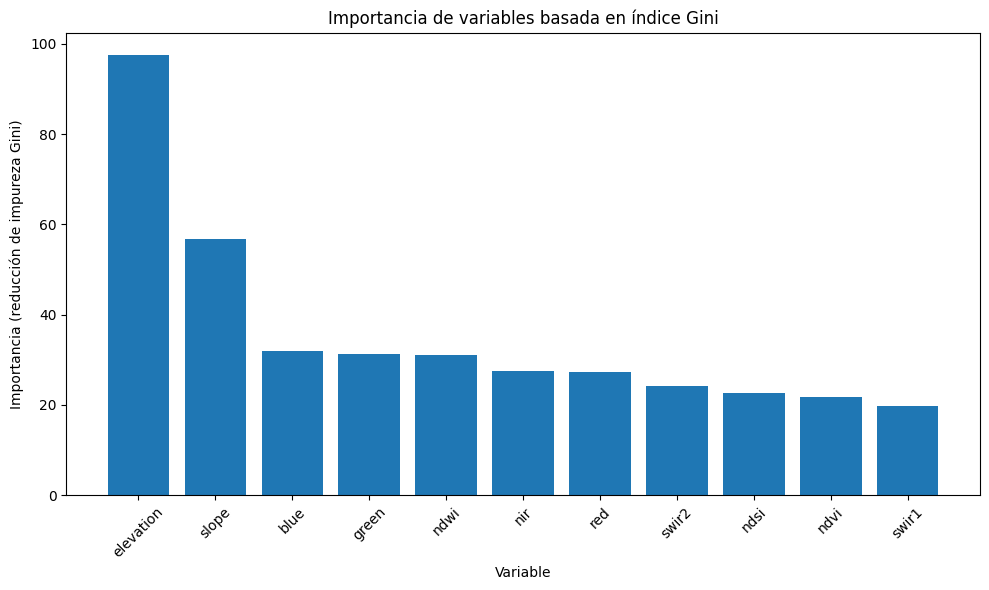

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2006 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,243,0,6,0,0,1,0
Vegetación,2,233,1,0,0,13,1
Cultivos,6,4,238,0,0,2,0
Nieve,0,0,0,249,0,0,1
Agua,1,1,0,0,248,0,0
Suelo,2,3,0,0,0,244,1
Suelo 2,0,11,0,6,0,1,232



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.972]
1,Vegetación,[0.932]
2,Cultivos,[0.952]
3,Nieve,[0.996]
4,Agua,[0.992]
5,Suelo,[0.976]
6,Suelo 2,[0.928]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9566929133858267, 0.9246031746031746, 0.971..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9640
Coeficiente Kappa: 0.9580
Clasificación para el año 2006 completada con éxito

Iniciando procesamiento para el año 2007
Número de imágenes para el año 2007: 107
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2007 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9408450704225352, 0.936231884057971, 0.9259259259259259, 0.9166666666666666, 0.9173553719008265]
Kappas por fold: [0.9309037657679365, 0.9255984472719428, 0.9132253801025016, 0.9026661286818335, 0.9033451969929618]
Accuracy promedio: 0.9274
Kappa promedio: 0.9151
Entrenando clasificador final...

=== Importancia de variables para el año 2007 ===
Importancia de variables (basada en reducción 

,Variable,Importancia
1,elevation,95.028523
8,slope,49.753228
0,blue,36.225589
7,red,31.815597
2,green,31.251548
5,ndwi,30.390051
3,ndsi,26.408647
6,nir,22.709615
4,ndvi,22.366555
10,swir2,19.514634


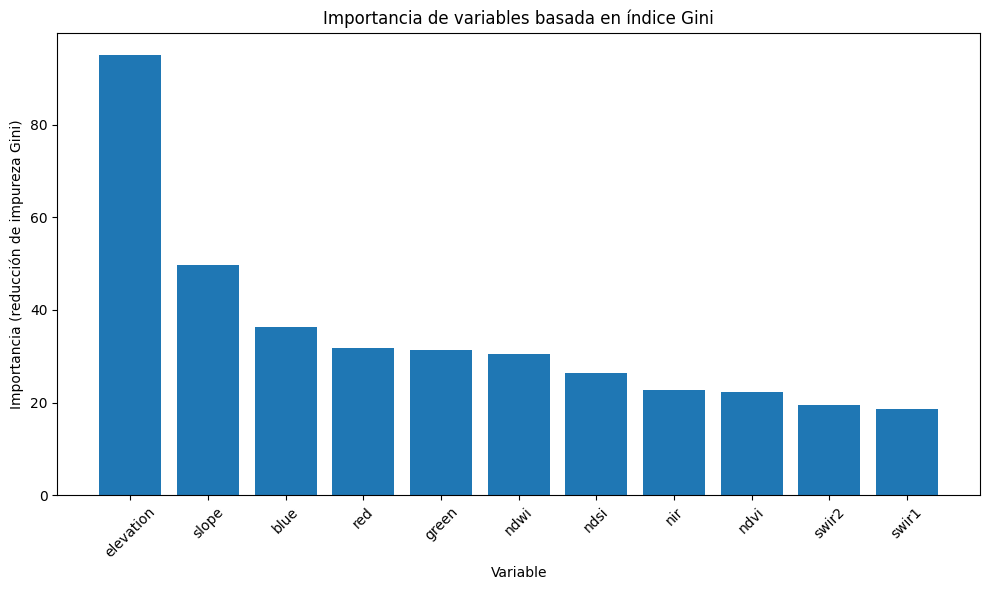

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2007 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,241,0,9,0,0,0,0
Vegetación,3,234,1,0,0,11,1
Cultivos,6,3,241,0,0,0,0
Nieve,0,0,0,247,0,0,3
Agua,1,1,0,0,248,0,0
Suelo,1,2,2,0,0,244,1
Suelo 2,0,11,0,5,1,0,233



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.964]
1,Vegetación,[0.936]
2,Cultivos,[0.964]
3,Nieve,[0.988]
4,Agua,[0.992]
5,Suelo,[0.976]
6,Suelo 2,[0.932]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9563492063492064, 0.9322709163346613, 0.952..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9646
Coeficiente Kappa: 0.9587
Clasificación para el año 2007 completada con éxito

Iniciando procesamiento para el año 2008
Número de imágenes para el año 2008: 114
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2008 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9352112676056338, 0.9333333333333333, 0.9401709401709402, 0.8988095238095238, 0.9090909090909091]
Kappas por fold: [0.9243596275881236, 0.9222363778910232, 0.9299354581143123, 0.8817648337317975, 0.8937532705970004]
Accuracy promedio: 0.9233
Kappa promedio: 0.9104
Entrenando clasificador final...

=== Importancia de variables para el año 2008 ===
Importancia de variables (basada en reducción

,Variable,Importancia
1,elevation,88.164840
8,slope,50.472300
5,ndwi,33.612202
0,blue,33.067646
2,green,28.955891
3,ndsi,28.932966
4,ndvi,27.181107
7,red,25.506517
6,nir,24.975345
10,swir2,19.851929


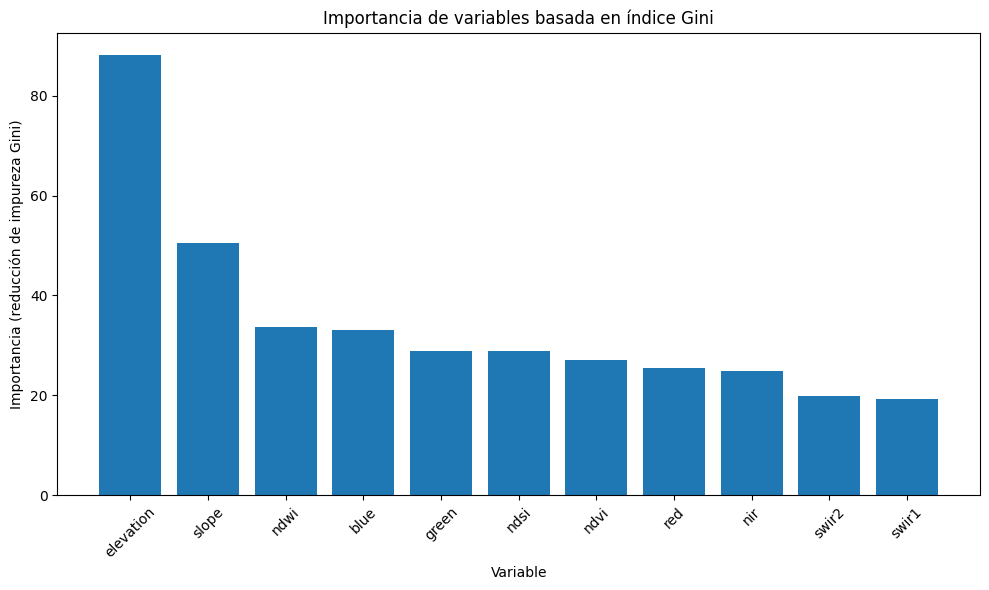

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2008 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,242,0,8,0,0,0,0
Vegetación,3,232,2,0,0,13,0
Cultivos,7,3,240,0,0,0,0
Nieve,0,0,0,247,0,0,3
Agua,1,0,0,0,249,0,0
Suelo,1,5,1,0,0,242,1
Suelo 2,0,11,0,4,1,0,234



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.968]
1,Vegetación,[0.928]
2,Cultivos,[0.96]
3,Nieve,[0.988]
4,Agua,[0.996]
5,Suelo,[0.968]
6,Suelo 2,[0.936]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.952755905511811, 0.9243027888446215, 0.9561..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9634
Coeficiente Kappa: 0.9573
Clasificación para el año 2008 completada con éxito

=== Procesando años 2009 a 2012 ===


Iniciando procesamiento para el año 2009
Número de imágenes para el año 2009: 106
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2009 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9323943661971831, 0.9217391304347826, 0.9287749287749287, 0.9226190476190477, 0.9090909090909091]
Kappas por fold: [0.9210570205511184, 0.908682737459194, 0.9166144021894064, 0.9096353762606673, 0.8937711721618218]
Accuracy promedio: 0.9229
Kappa promedio: 0.9100
Entrenando clasificador final...

=== Importancia de variables para el año 2009 ===
Importan

,Variable,Importancia
1,elevation,110.710609
8,slope,63.301075
0,blue,38.598151
5,ndwi,37.118513
4,ndvi,36.071562
2,green,33.847265
6,nir,28.321677
3,ndsi,26.859902
7,red,24.233460
9,swir1,21.341640


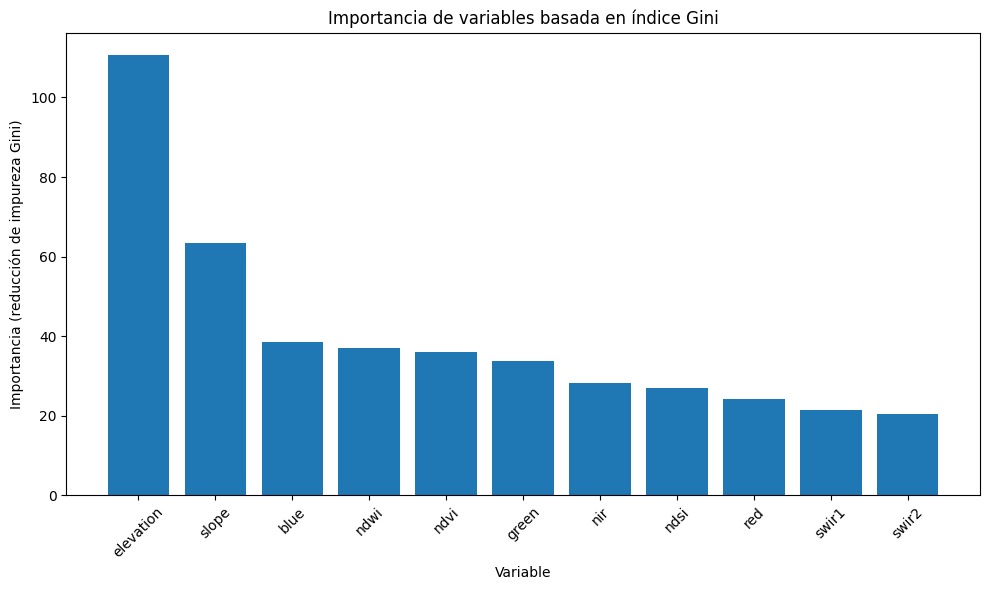

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2009 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,242,0,8,0,0,0,0
Vegetación,2,238,1,0,0,8,1
Cultivos,4,1,245,0,0,0,0
Nieve,0,0,0,248,0,0,2
Agua,3,0,0,0,247,0,0
Suelo,1,8,0,0,0,241,0
Suelo 2,0,13,0,7,1,0,229



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.968]
1,Vegetación,[0.952]
2,Cultivos,[0.98]
3,Nieve,[0.992]
4,Agua,[0.988]
5,Suelo,[0.964]
6,Suelo 2,[0.916]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9603174603174603, 0.9153846153846154, 0.964..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9657
Coeficiente Kappa: 0.9600
Clasificación para el año 2009 completada con éxito

Iniciando procesamiento para el año 2011
Número de imágenes para el año 2011: 84
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2011 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9464788732394366, 0.9014492753623189, 0.9344729344729344, 0.8988095238095238, 0.9228650137741047]
Kappas por fold: [0.9375225780157281, 0.8850371938490489, 0.9232319966527516, 0.8818443207910143, 0.9099016044676891]
Accuracy promedio: 0.9208
Kappa promedio: 0.9075
Entrenando clasificador final...

=== Importancia de variables para el año 2011 ===
Importancia de variables (basada en reducción 

,Variable,Importancia
1,elevation,93.753234
8,slope,54.762033
0,blue,39.180308
5,ndwi,32.588062
2,green,31.677881
3,ndsi,27.888142
4,ndvi,25.225999
7,red,24.618228
10,swir2,23.535036
6,nir,21.908799


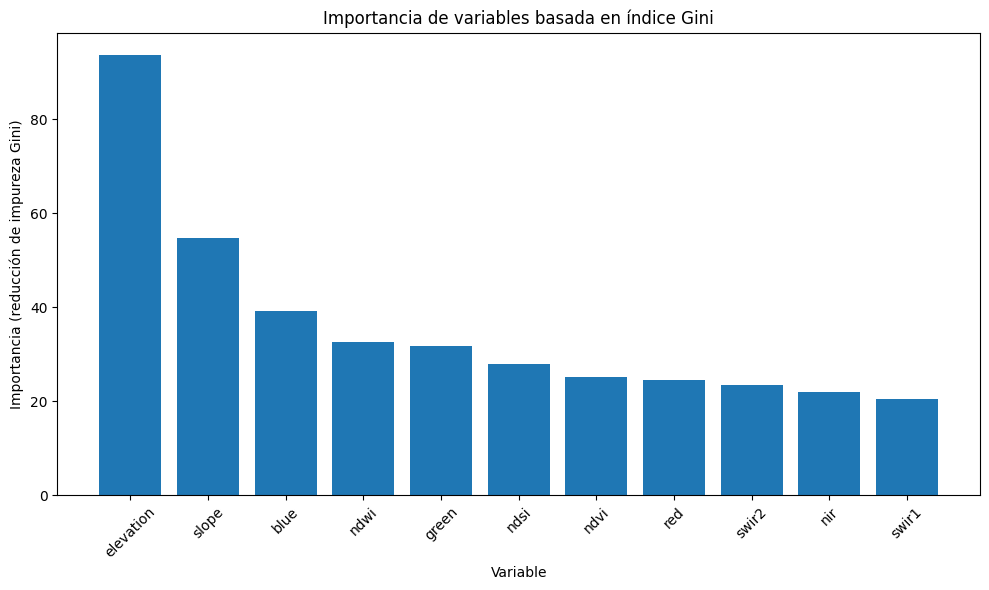

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2011 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,248,0,2,0,0,0,0
Vegetación,2,238,1,0,0,9,0
Cultivos,4,1,243,0,0,2,0
Nieve,0,0,0,249,0,0,1
Agua,0,0,0,0,250,0,0
Suelo,1,4,1,0,0,244,0
Suelo 2,0,10,0,6,1,0,233



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.992]
1,Vegetación,[0.952]
2,Cultivos,[0.972]
3,Nieve,[0.996]
4,Agua,[1]
5,Suelo,[0.976]
6,Suelo 2,[0.932]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9725490196078431, 0.9407114624505929, 0.983..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9743
Coeficiente Kappa: 0.9700
Clasificación para el año 2011 completada con éxito

Iniciando procesamiento para el año 2012
Número de imágenes para el año 2012: 62
Umbral de nubes utilizado: 20%
Muestreando valores de bandas para puntos de entrenamiento...
Verificando diversidad de clases en los datos de entrenamiento...
Se encontraron 7 clases en los datos de entrenamiento
Distribución de clases: {0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250}

=== Validación cruzada para el año 2012 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9492957746478873, 0.936231884057971, 0.9259259259259259, 0.9434523809523809, 0.9228650137741047]
Kappas por fold: [0.940786181589043, 0.9256028229758869, 0.9133086349387289, 0.9339595315926676, 0.9098880249660883]
Accuracy promedio: 0.9356
Kappa promedio: 0.9247
Entrenando clasificador final...

=== Importancia de variables para el año 2012 ===
Importancia de variables (basada en reducción de

,Variable,Importancia
1,elevation,94.954715
8,slope,57.837119
0,blue,32.491070
2,green,31.434912
7,red,25.371944
5,ndwi,24.004209
9,swir1,22.665957
4,ndvi,21.058546
6,nir,20.017744
10,swir2,18.159442


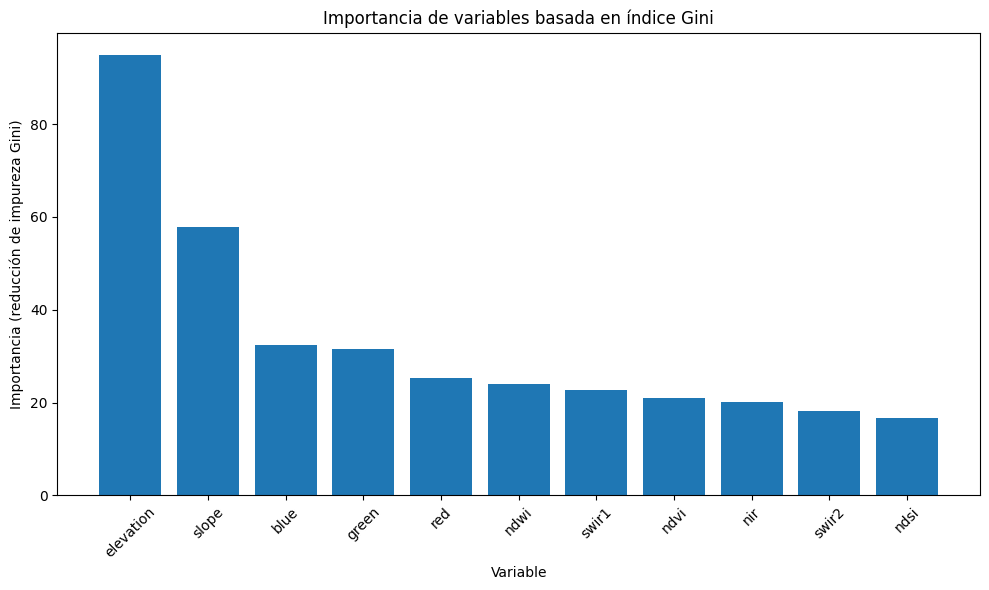

Aplicando clasificador a la imagen...

=== Matriz de confusión para el año 2012 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,245,0,5,0,0,0,0
Vegetación,2,234,1,0,0,13,0
Cultivos,0,2,248,0,0,0,0
Nieve,0,0,0,249,0,0,1
Agua,2,0,0,0,248,0,0
Suelo,1,3,1,0,0,245,0
Suelo 2,0,14,0,7,1,0,228



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.98]
1,Vegetación,[0.936]
2,Cultivos,[0.992]
3,Nieve,[0.996]
4,Agua,[0.992]
5,Suelo,[0.98]
6,Suelo 2,[0.912]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.98, 0.924901185770751, 0.9725490196078431, ..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9697
Coeficiente Kappa: 0.9647
Clasificación para el año 2012 completada con éxito

¿Deseas exportar los resultados a Google Drive? (s/n): s
Tarea de exportación iniciada para el año 1994
Tarea de exportación iniciada para el año 1985
Tarea de exportación iniciada para el año 1990
Tarea de exportación iniciada para el año 2000
Tarea de exportación iniciada para el año 2010
Tarea de exportación iniciada para el año 1986
Tarea de exportación iniciada para el año 1987
Tarea de exportación iniciada para el año 1988
Tarea de exportación iniciada para el año 1989
Tarea de exportación iniciada para el año 1991
Tarea de exportación iniciada para el año 1992
Tarea de exportación iniciada para el año 1993
Tarea de exportación iniciada para el año 1996
Tarea de exportación iniciada para el año 1997
Tarea de exportación iniciada para el año 1998
Tarea de exportación iniciada para el año 1999
Tarea de exportación iniciada para el año 2001
Tarea de exportación

Map(center=[-36.60356114299189, -71.94760206715729], controls=(WidgetControl(options=['position', 'transparent…


=== Resumen final de procesamiento ===
Total de años clasificados con éxito: 27
Años clasificados: [1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Años con problemas: [1995]


In [ ]:
# Definir lista de años que podrían ser problemáticos para diagnosticar primero
años_prueba = [1994, 1985, 1990, 2000, 2010]  # Incluir el año problemático (1994) primero
print("\n=== Prueba inicial con años seleccionados ===")

# Procesar años de prueba primero
clasificaciones_prueba = []
años_exitosos = []
años_fallidos = []

for año in años_prueba:
    print(f"\n=== Procesando año de prueba: {año} ===")
    resultado = clasificarAño(año)
    if resultado is not None:
        clasificaciones_prueba.append(resultado)
        años_exitosos.append(año)
        print(f"Clasificación para el año {año} completada con éxito")
    else:
        años_fallidos.append(año)
        print(f"No se pudo completar la clasificación para el año {año}")

print("\n=== Resumen de prueba inicial ===")
print(f"Años clasificados con éxito: {años_exitosos}")
print(f"Años con problemas: {años_fallidos}")

# Preguntar si continuar con todos los años
respuesta = input("\n¿Deseas continuar con el procesamiento de todos los años? (s/n): ")

if respuesta.lower() == 's':
    # Procesar el resto de los años en lotes
    años_restantes = [año for año in range(1985, 2013) if año not in años_prueba]
    batch_size = 5  # Procesar 5 años por lote

    clasificaciones = clasificaciones_prueba.copy()  # Inicializar con los años de prueba exitosos

    for i in range(0, len(años_restantes), batch_size):
        # Obtener un lote de años para procesar
        años_lote = años_restantes[i:i+batch_size]
        print(f"\n=== Procesando años {años_lote[0]} a {años_lote[-1]} ===\n")

        # Procesar cada año en el lote
        for año in años_lote:
            if año in años_fallidos:
                print(f"Omitiendo año {año} (previamente identificado como problemático)")
                continue

            print(f"\nIniciando procesamiento para el año {año}")
            resultado = clasificarAño(año)
            if resultado is not None:
                clasificaciones.append(resultado)
                print(f"Clasificación para el año {año} completada con éxito")
            else:
                años_fallidos.append(año)
                print(f"No se pudo completar la clasificación para el año {año}")

    # Definir paleta de colores para la visualización
    palette = [
        '#FF0000',  # urbano - rojo
        '#00FF00',  # vegetación - verde
        '#FFFF00',  # cultivos - amarillo
        '#FFFFFF',  # nieve - blanco
        '#0000FF',  # agua - azul
        '#FF9900',  # suelo - naranja
        '#994C00'   # suelo2 - marrón
    ]

    # Visualizar las clasificaciones en el mapa
    for i, classifiedROI in enumerate(clasificaciones):
        año = classifiedROI.get('year').getInfo()
        Map.addLayer(classifiedROI, {'min': 0, 'max': 6, 'palette': palette}, f'Clasificación {año}')

    # Añadir selector de capas al mapa
    Map.add_layer_control()

    # Exportar resultados
    respuesta_export = input("\n¿Deseas exportar los resultados a Google Drive? (s/n): ")
    if respuesta_export.lower() == 's':
        for i, classifiedROI in enumerate(clasificaciones):
            año = classifiedROI.get('year').getInfo()
            task = ee.batch.Export.image.toDrive(
                image=classifiedROI,
                description=f'Clasificacion_{año}',
                folder='EarthEngine_Historico',
                region=roi,
                scale=30,
                maxPixels=1e13
            )
            task.start()
            print(f'Tarea de exportación iniciada para el año {año}')

    # Mostrar el mapa interactivo
    display(Map)

    # Mostrar resumen final
    print("\n=== Resumen final de procesamiento ===")
    años_exitosos = [img.get('year').getInfo() for img in clasificaciones]
    años_exitosos.sort()
    print(f"Total de años clasificados con éxito: {len(años_exitosos)}")
    print(f"Años clasificados: {años_exitosos}")
    print(f"Años con problemas: {años_fallidos}")
else:
    print("Procesamiento cancelado por el usuario.")